In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Quick fits for TESS light curves

In this tutorial, we will fit the TESS light curve for a known transiting planet.
While the :ref:`tess` tutorial goes through the full details of an end-to-end fit, this tutorial is significantly faster to run and it can give pretty excellent results depending on your goals.
Some of the main differences are:

1. We start from the light curve rather than doing the photometry ourselves. This should pretty much always be fine unless you have a very bright, faint, or crowded target.
2. We assume a circluar orbit, but as you'll see later, we can approximately relax this assumption later.
3. We only fit the data near transit. In many cases this will be just fine, but if you have predictable stellar variability (like coherent rotation) then you might do better fitting more data.

We'll fit the planet in the HD 118203 (TIC 286923464) system that was found to transit by [Pepper et al. (2019)](https://arxiv.org/abs/1911.05150) because it is on an eccentric orbit so assumption #2 above is not valid.

First, let's download the TESS light curve using [lightkurve](https://docs.lightkurve.org/):

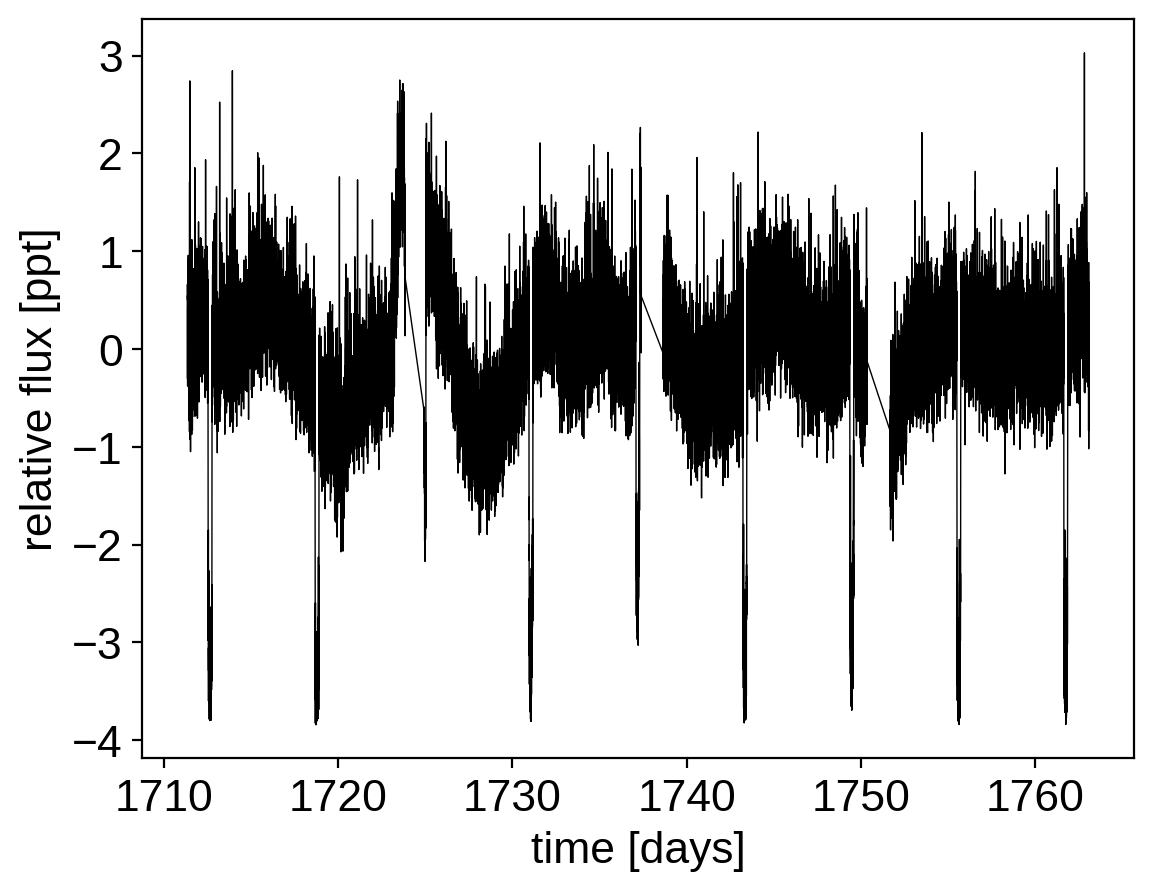

In [3]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

lcfs = lk.search_lightcurvefile("TIC 286923464", mission="TESS").download_all()
lc = lcfs.PDCSAP_FLUX.stitch()
lc = lc.remove_nans().remove_outliers()

x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (lc.flux - 1), dtype=np.float64)
yerr = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

texp = np.min(np.diff(x))

plt.plot(x, y, "k", linewidth=0.5)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]");

Then, find the period, phase and depth of the transit using box least squares:

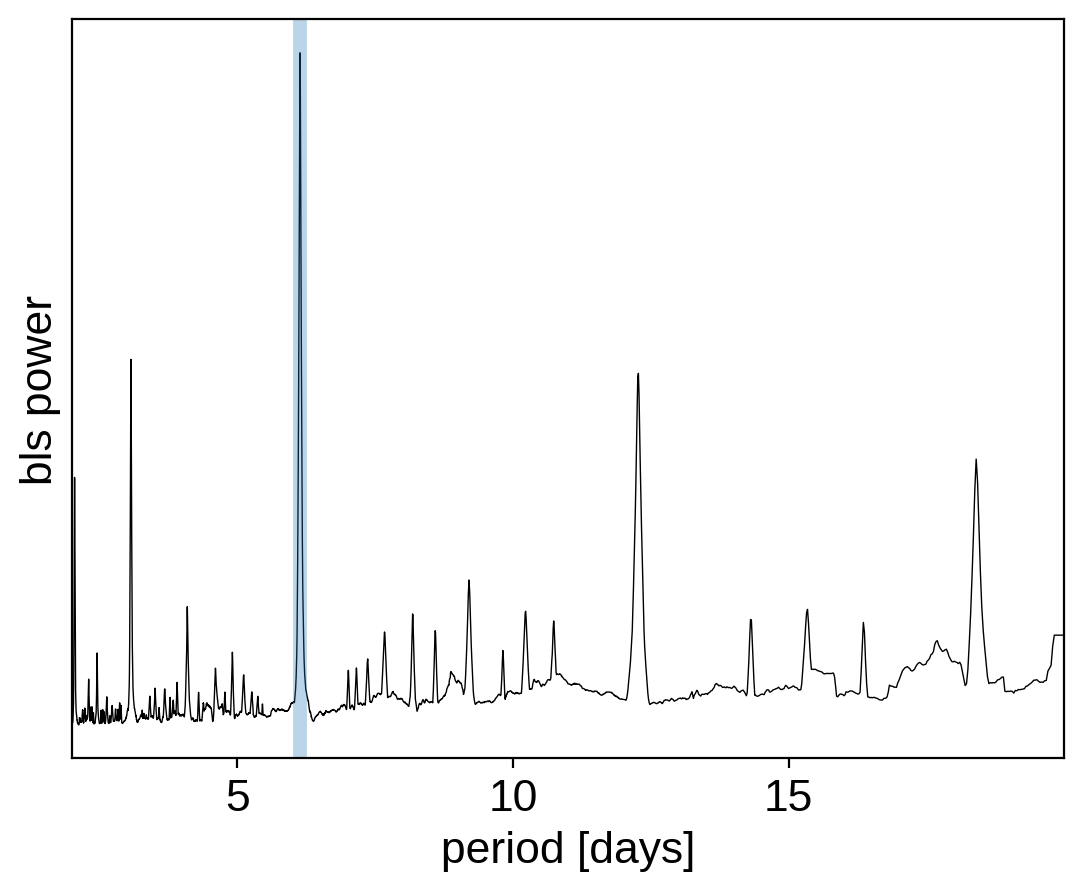

In [4]:
import exoplanet as xo

pg = xo.estimators.bls_estimator(x, y, yerr, min_period=2, max_period=20)

peak = pg["peak_info"]
period_guess = peak["period"]
t0_guess = peak["transit_time"]
depth_guess = peak["depth"]

plt.plot(pg["bls"].period, pg["bls"].power, "k", linewidth=0.5)
plt.axvline(period_guess, alpha=0.3, linewidth=5)
plt.xlabel("period [days]")
plt.ylabel("bls power")
plt.yticks([])
plt.xlim(pg["bls"].period.min(), pg["bls"].period.max());

Then, for efficiency purposes, let's extract just the data within 0.25 days of the transits:

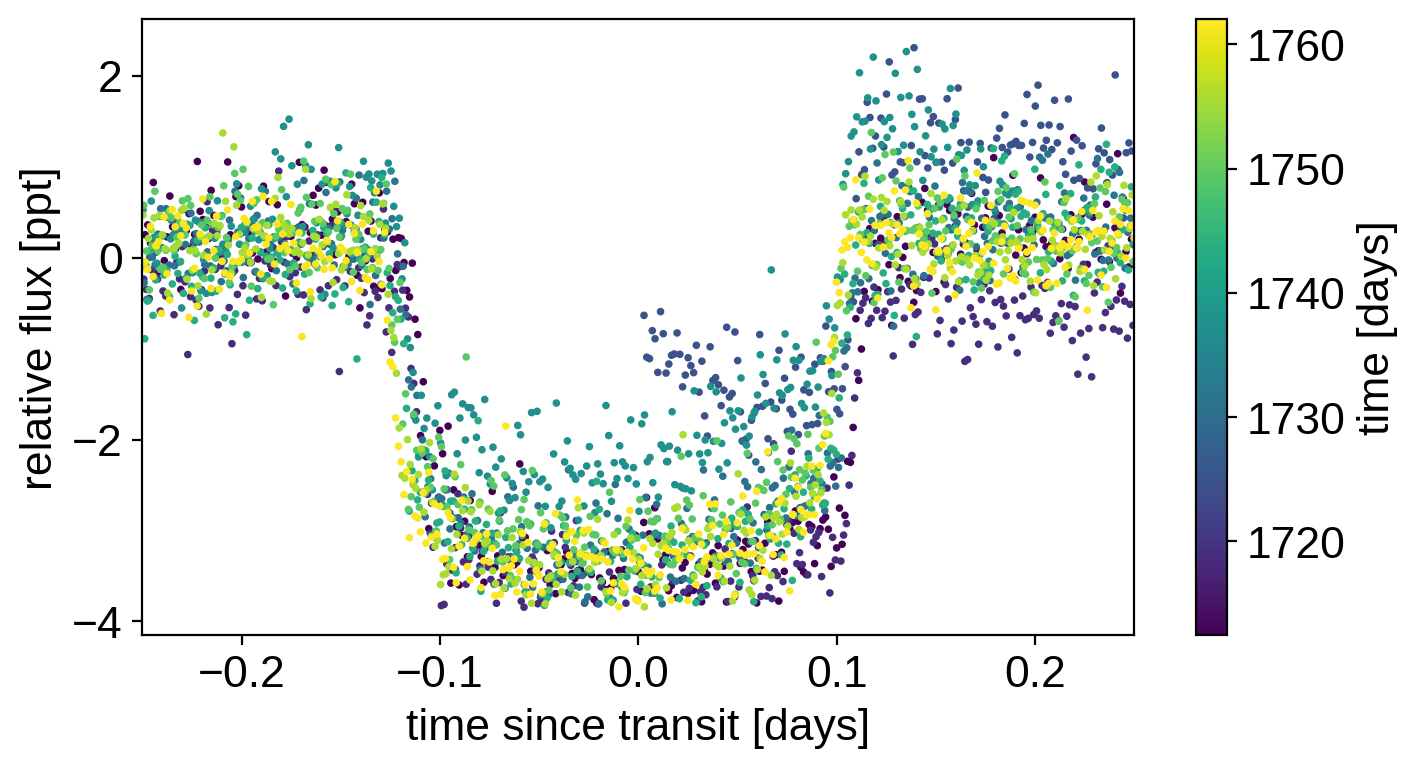

In [5]:
transit_mask = (
    np.abs((x - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess)
    < 0.25
)
x = np.ascontiguousarray(x[transit_mask])
y = np.ascontiguousarray(y[transit_mask])
yerr = np.ascontiguousarray(yerr[transit_mask])

plt.figure(figsize=(8, 4))
x_fold = (x - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess
plt.scatter(x_fold, y, c=x, s=3)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
plt.xlim(-0.25, 0.25);

That looks a little janky, but it's good enough for now.

## The probabilistic model

Here's how we set up the PyMC3 model in this case:

In [6]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Stellar parameters
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)
    u = xo.distributions.QuadLimbDark("u")
    star_params = [mean, u]

    # Gaussian process noise model
    sigma = pm.InverseGamma("sigma", alpha=3.0, beta=2 * np.median(yerr))
    log_Sw4 = pm.Normal("log_Sw4", mu=0.0, sigma=10.0)
    log_w0 = pm.Normal("log_w0", mu=np.log(2 * np.pi / 10.0), sigma=10.0)
    kernel = xo.gp.terms.SHOTerm(log_Sw4=log_Sw4, log_w0=log_w0, Q=1.0 / 3)
    noise_params = [sigma, log_Sw4, log_w0]

    # Planet parameters
    log_ror = pm.Normal("log_ror", mu=0.5 * np.log(depth_guess * 1e-3), sigma=10.0)
    ror = pm.Deterministic("ror", tt.exp(log_ror))

    # Orbital parameters
    log_period = pm.Normal("log_period", mu=np.log(period_guess), sigma=1.0)
    t0 = pm.Normal("t0", mu=t0_guess, sigma=1.0)
    log_dur = pm.Normal("log_dur", mu=np.log(0.1), sigma=10.0)
    b = xo.distributions.ImpactParameter("b", ror=ror)

    period = pm.Deterministic("period", tt.exp(log_period))
    dur = pm.Deterministic("dur", tt.exp(log_dur))

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(period=period, duration=dur, t0=t0, b=b,)

    # We're going to track the implied density for reasons that will become clear later
    pm.Deterministic("rho_circ", orbit.rho_star)

    # Set up the mean transit model
    star = xo.LimbDarkLightCurve(u)

    def lc_model(t):
        return mean + 1e3 * tt.sum(
            star.get_light_curve(orbit=orbit, r=ror, t=t), axis=-1
        )

    # Finally the GP observation model
    gp = xo.gp.GP(kernel, x, yerr ** 2 + sigma ** 2, mean=lc_model)
    gp.marginal("obs", observed=y)

    # Double check that everything looks good - we shouldn't see any NaNs!
    print(model.check_test_point())

    # Optimize the model
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [sigma])
    map_soln = xo.optimize(map_soln, [log_ror, b, log_dur])
    map_soln = xo.optimize(map_soln, noise_params)
    map_soln = xo.optimize(map_soln, star_params)
    map_soln = xo.optimize(map_soln)

mean                   -3.22
u_quadlimbdark__       -2.77
sigma_log__            -0.53
log_Sw4                -3.22
log_w0                 -3.22
log_ror                -3.22
log_period             -0.92
t0                     -0.92
log_dur                -3.22
b_impact__             -1.39
obs                -19675.38
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.969802e+04]

1it [00:00, 133.20it/s, logp=-1.969802e+04]

2it [00:00, 189.48it/s, logp=-1.005396e+04]

3it [00:00, 224.58it/s, logp=-1.184812e+04]

4it [00:00, 248.92it/s, logp=-7.511770e+03]

5it [00:00, 271.37it/s, logp=-2.394251e+04]

6it [00:00, 288.86it/s, logp=-5.828561e+03]

7it [00:00, 301.53it/s, logp=-2.398060e+04]

8it [00:00, 313.34it/s, logp=-5.056316e+03]

9it [00:00, 325.73it/s, logp=-5.022735e+03]

10it [00:00, 337.52it/s, logp=-4.956838e+03]

11it [00:00, 346.40it/s, logp=-4.955375e+03]

12it [00:00, 354.65it/s, logp=-4.955330e+03]

13it [00:00, 362.95it/s, logp=-4.955330e+03]

14it [00:00, 371.17it/s, logp=-4.955330e+03]

15it [00:01,  9.11it/s, logp=-4.955330e+03] 


message: Optimization terminated successfully.
logp: -19698.019519076297 -> -4955.329659550934


optimizing logp for variables: [log_dur, b, log_ror]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.955330e+03]

1it [00:00, 173.28it/s, logp=-4.955330e+03]

2it [00:00, 225.11it/s, logp=-4.845883e+03]

3it [00:00, 264.29it/s, logp=-4.785562e+03]

4it [00:00, 292.32it/s, logp=-4.666357e+03]

5it [00:00, 309.89it/s, logp=-4.579039e+03]

6it [00:00, 330.43it/s, logp=-4.584320e+03]

7it [00:00, 343.29it/s, logp=-4.204053e+03]

8it [00:00, 362.23it/s, logp=-5.603027e+03]

9it [00:00, 372.71it/s, logp=-4.204053e+03]

10it [00:00, 382.37it/s, logp=-4.204053e+03]

11it [00:00, 396.11it/s, logp=-5.603027e+03]

12it [00:00, 400.42it/s, logp=-4.085348e+03]

13it [00:00, 404.09it/s, logp=-3.872703e+03]

14it [00:00, 408.70it/s, logp=-3.827631e+03]

15it [00:00, 413.17it/s, logp=-3.738097e+03]

16it [00:00, 414.93it/s, logp=-3.718078e+03]

17it [00:00, 418.14it/s, logp=-3.708255e+03]

18it [00:00, 421.24it/s, logp=-3.704491e+03]

19it [00:00, 424.22it/s, logp=-3.700526e+03]

20it [00:00, 427.15it/s, logp=-3.698575e+03]

21it [00:00, 430.45it/s, logp=-3.697983e+03]

22it [00:00, 432.47it/s, logp=-3.697899e+03]

23it [00:00, 435.35it/s, logp=-3.697894e+03]

24it [00:00, 437.85it/s, logp=-3.697894e+03]

25it [00:00, 439.78it/s, logp=-3.697894e+03]

26it [00:00, 442.35it/s, logp=-3.697894e+03]

27it [00:00, 444.29it/s, logp=-3.697894e+03]

28it [00:00, 445.67it/s, logp=-3.697894e+03]

29it [00:00, 160.51it/s, logp=-3.697894e+03]


message: Optimization terminated successfully.
logp: -4955.329659550934 -> -3697.8937293910903


optimizing logp for variables: [log_w0, log_Sw4, sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-3.697894e+03]

1it [00:00, 153.60it/s, logp=-3.697894e+03]

2it [00:00, 214.17it/s, logp=-2.171194e+03]

3it [00:00, 241.04it/s, logp=-inf]         

4it [00:00, 266.45it/s, logp=-2.171194e+03]

5it [00:00, 287.58it/s, logp=-2.171194e+03]

6it [00:00, 305.25it/s, logp=-inf]         

7it [00:00, 309.56it/s, logp=-inf]

8it [00:00, 321.21it/s, logp=-1.836850e+03]

9it [00:00, 332.36it/s, logp=-inf]         

10it [00:00, 342.09it/s, logp=-1.836850e+03]

11it [00:00, 350.97it/s, logp=-1.836850e+03]

12it [00:00, 359.52it/s, logp=-inf]         

13it [00:00, 365.72it/s, logp=-1.766314e+03]

14it [00:00, 370.56it/s, logp=-1.836628e+03]

15it [00:00, 375.72it/s, logp=-1.740021e+03]

16it [00:00, 379.61it/s, logp=-1.708452e+03]

17it [00:00, 383.05it/s, logp=-1.632457e+03]

18it [00:00, 387.41it/s, logp=-1.707046e+03]

19it [00:00, 391.42it/s, logp=-1.617209e+03]

20it [00:00, 394.90it/s, logp=-1.567400e+03]

21it [00:00, 398.15it/s, logp=-1.566973e+03]

22it [00:00, 400.64it/s, logp=-1.566200e+03]

23it [00:00, 402.65it/s, logp=-8.233007e+03]

24it [00:00, 405.48it/s, logp=-1.567607e+03]

25it [00:00, 408.03it/s, logp=-1.565957e+03]

26it [00:00, 409.84it/s, logp=-1.565467e+03]

27it [00:00, 412.36it/s, logp=-1.563510e+03]

28it [00:00, 414.40it/s, logp=-1.555776e+03]

29it [00:00, 416.37it/s, logp=-1.526799e+03]

30it [00:00, 417.87it/s, logp=-1.474944e+03]

31it [00:00, 419.22it/s, logp=-1.470930e+03]

32it [00:00, 420.50it/s, logp=-1.469122e+03]

33it [00:00, 421.89it/s, logp=-1.465759e+03]

34it [00:00, 423.55it/s, logp=-1.460094e+03]

35it [00:00, 425.11it/s, logp=-1.459472e+03]

36it [00:00, 416.08it/s, logp=-1.457742e+03]

37it [00:00, 383.87it/s, logp=-1.457543e+03]

38it [00:00, 377.87it/s, logp=-1.457536e+03]

39it [00:00, 383.05it/s, logp=-1.457536e+03]

39it [00:00, 383.05it/s, logp=-1.457535e+03]

40it [00:00, 383.05it/s, logp=-1.457535e+03]

41it [00:00, 383.05it/s, logp=-1.457535e+03]

42it [00:00, 383.05it/s, logp=-1.457535e+03]

43it [00:00, 183.61it/s, logp=-1.457535e+03]


message: Optimization terminated successfully.
logp: -3697.893729391091 -> -1457.5349667849082


optimizing logp for variables: [u, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.457535e+03]

1it [00:00, 149.48it/s, logp=-1.457535e+03]

2it [00:00, 217.03it/s, logp=-1.501306e+03]

3it [00:00, 260.55it/s, logp=-1.451771e+03]

4it [00:00, 286.00it/s, logp=-1.456218e+03]

5it [00:00, 311.61it/s, logp=-1.451575e+03]

6it [00:00, 328.50it/s, logp=-1.451379e+03]

7it [00:00, 341.64it/s, logp=-1.451379e+03]

8it [00:00, 352.63it/s, logp=-1.451379e+03]

9it [00:00, 363.60it/s, logp=-1.451379e+03]

10it [00:00, 374.16it/s, logp=-1.451379e+03]

11it [00:00, 24.76it/s, logp=-1.451379e+03] 


message: Optimization terminated successfully.
logp: -1457.5349667849082 -> -1451.3790246464287


optimizing logp for variables: [b, log_dur, t0, log_period, log_ror, log_w0, log_Sw4, sigma, u, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.451379e+03]

1it [00:00, 171.75it/s, logp=-1.451379e+03]

2it [00:00, 243.41it/s, logp=-1.920070e+03]

3it [00:00, 294.61it/s, logp=-1.865041e+03]

4it [00:00, 330.20it/s, logp=-1.838697e+03]

5it [00:00, 354.13it/s, logp=-1.910560e+03]

6it [00:00, 366.01it/s, logp=-1.928171e+03]

7it [00:00, 374.44it/s, logp=-1.531115e+03]

8it [00:00, 381.01it/s, logp=-1.438706e+03]

9it [00:00, 380.38it/s, logp=-1.417968e+03]

10it [00:00, 384.83it/s, logp=-1.431133e+03]

11it [00:00, 390.17it/s, logp=-1.407770e+03]

12it [00:00, 391.78it/s, logp=-1.391258e+03]

13it [00:00, 394.67it/s, logp=-1.394009e+03]

14it [00:00, 398.21it/s, logp=-1.381828e+03]

15it [00:00, 400.32it/s, logp=-1.446055e+03]

16it [00:00, 403.02it/s, logp=-1.381096e+03]

17it [00:00, 404.16it/s, logp=-1.379682e+03]

18it [00:00, 406.63it/s, logp=-1.375331e+03]

19it [00:00, 407.92it/s, logp=-1.395933e+03]

20it [00:00, 407.30it/s, logp=-1.373929e+03]

21it [00:00, 407.93it/s, logp=-1.371312e+03]

22it [00:00, 408.81it/s, logp=-1.366448e+03]

23it [00:00, 409.27it/s, logp=-1.357500e+03]

24it [00:00, 410.16it/s, logp=-1.340417e+03]

25it [00:00, 411.04it/s, logp=-1.309458e+03]

26it [00:00, 411.87it/s, logp=-1.274616e+03]

27it [00:00, 412.34it/s, logp=-1.243616e+03]

28it [00:00, 413.31it/s, logp=-1.233852e+03]

29it [00:00, 413.90it/s, logp=-1.220348e+03]

30it [00:00, 414.71it/s, logp=-1.208340e+03]

31it [00:00, 415.36it/s, logp=-1.202944e+03]

32it [00:00, 416.07it/s, logp=-1.199545e+03]

33it [00:00, 416.73it/s, logp=-1.193326e+03]

34it [00:00, 417.28it/s, logp=-1.182029e+03]

35it [00:00, 417.91it/s, logp=-1.249828e+03]

36it [00:00, 419.22it/s, logp=-1.179033e+03]

37it [00:00, 419.66it/s, logp=-1.174473e+03]

38it [00:00, 420.14it/s, logp=-1.167968e+03]

39it [00:00, 420.62it/s, logp=-1.162836e+03]

40it [00:00, 420.84it/s, logp=-1.162392e+03]

41it [00:00, 421.72it/s, logp=-1.160394e+03]

42it [00:00, 422.01it/s, logp=-1.159249e+03]

43it [00:00, 429.85it/s, logp=-1.159249e+03]

43it [00:00, 429.85it/s, logp=-1.158505e+03]

44it [00:00, 429.85it/s, logp=-1.158152e+03]

45it [00:00, 429.85it/s, logp=-1.157931e+03]

46it [00:00, 429.85it/s, logp=-1.157733e+03]

47it [00:00, 429.85it/s, logp=-1.157677e+03]

48it [00:00, 429.85it/s, logp=-1.157651e+03]

49it [00:00, 429.85it/s, logp=-1.157637e+03]

50it [00:00, 429.85it/s, logp=-1.157612e+03]

51it [00:00, 429.85it/s, logp=-1.157574e+03]

52it [00:00, 429.85it/s, logp=-1.157545e+03]

53it [00:00, 429.85it/s, logp=-1.157538e+03]

54it [00:00, 429.85it/s, logp=-1.157536e+03]

55it [00:00, 429.85it/s, logp=-1.157536e+03]

56it [00:00, 429.85it/s, logp=-1.157536e+03]

57it [00:00, 429.85it/s, logp=-1.157536e+03]

58it [00:00, 429.85it/s, logp=-1.157536e+03]

59it [00:00, 429.85it/s, logp=-1.157536e+03]

60it [00:00, 429.85it/s, logp=-1.157536e+03]

61it [00:00, 429.85it/s, logp=-1.157536e+03]

62it [00:00, 429.85it/s, logp=-1.157536e+03]

63it [00:00, 429.85it/s, logp=-1.157536e+03]

64it [00:00, 429.85it/s, logp=-1.157536e+03]

65it [00:00, 429.85it/s, logp=-1.157536e+03]

66it [00:00, 429.85it/s, logp=-1.157536e+03]

67it [00:00, 429.85it/s, logp=-1.157536e+03]

68it [00:00, 429.85it/s, logp=-1.157536e+03]

69it [00:00, 429.85it/s, logp=-1.157536e+03]

70it [00:00, 429.85it/s, logp=-1.157536e+03]

71it [00:00, 429.85it/s, logp=-1.157536e+03]

72it [00:00, 429.85it/s, logp=-1.157536e+03]

73it [00:00, 429.85it/s, logp=-1.157536e+03]

74it [00:00, 429.85it/s, logp=-1.157536e+03]

75it [00:00, 429.85it/s, logp=-1.157536e+03]

76it [00:00, 429.85it/s, logp=-1.157536e+03]

77it [00:00, 429.85it/s, logp=-1.157536e+03]

78it [00:00, 429.85it/s, logp=-1.157536e+03]

79it [00:00, 429.85it/s, logp=-1.157536e+03]

80it [00:00, 429.85it/s, logp=-1.157536e+03]

81it [00:00, 429.85it/s, logp=-1.157536e+03]

82it [00:00, 429.85it/s, logp=-1.157536e+03]

83it [00:00, 429.85it/s, logp=-1.157536e+03]

84it [00:00, 429.85it/s, logp=-1.157536e+03]

85it [00:00, 429.85it/s, logp=-1.157536e+03]

86it [00:00, 429.85it/s, logp=-1.157536e+03]

87it [00:00, 429.85it/s, logp=-1.157536e+03]

88it [00:00, 435.58it/s, logp=-1.157536e+03]

88it [00:00, 435.58it/s, logp=-1.157536e+03]

89it [00:00, 435.58it/s, logp=-1.157536e+03]

90it [00:00, 435.58it/s, logp=-1.157536e+03]

91it [00:00, 435.58it/s, logp=-1.157536e+03]

92it [00:00, 435.58it/s, logp=-1.157536e+03]

93it [00:00, 435.58it/s, logp=-1.157536e+03]

94it [00:00, 435.58it/s, logp=-1.157536e+03]

95it [00:00, 435.58it/s, logp=-1.157536e+03]

96it [00:00, 435.58it/s, logp=-1.157536e+03]

97it [00:00, 435.58it/s, logp=-1.157536e+03]

98it [00:00, 435.58it/s, logp=-1.157536e+03]

99it [00:00, 435.58it/s, logp=-1.157536e+03]

100it [00:00, 435.58it/s, logp=-1.157536e+03]

101it [00:00, 435.58it/s, logp=-1.157536e+03]

102it [00:00, 435.58it/s, logp=-1.157536e+03]

103it [00:00, 435.58it/s, logp=-1.157536e+03]

104it [00:00, 435.58it/s, logp=-1.157536e+03]

105it [00:00, 435.58it/s, logp=-1.157536e+03]

106it [00:00, 435.58it/s, logp=-1.157536e+03]

107it [00:00, 435.58it/s, logp=-1.157536e+03]

108it [00:00, 435.58it/s, logp=-1.157536e+03]

109it [00:00, 435.58it/s, logp=-1.157536e+03]

110it [00:00, 435.58it/s, logp=-1.157536e+03]

111it [00:00, 435.58it/s, logp=-1.157536e+03]

112it [00:00, 435.58it/s, logp=-1.157536e+03]

113it [00:00, 435.58it/s, logp=-1.157536e+03]

114it [00:00, 435.58it/s, logp=-1.157536e+03]

115it [00:00, 435.58it/s, logp=-1.157536e+03]

116it [00:00, 435.58it/s, logp=-1.157536e+03]

117it [00:00, 435.58it/s, logp=-1.157536e+03]

118it [00:00, 435.58it/s, logp=-1.157536e+03]

119it [00:00, 435.58it/s, logp=-1.157536e+03]

120it [00:00, 435.58it/s, logp=-1.157536e+03]

121it [00:00, 435.58it/s, logp=-1.157536e+03]

122it [00:00, 435.58it/s, logp=-1.157536e+03]

123it [00:00, 435.58it/s, logp=-1.157536e+03]

124it [00:00, 435.58it/s, logp=-1.157536e+03]

125it [00:00, 435.58it/s, logp=-1.157536e+03]

126it [00:00, 435.58it/s, logp=-1.157536e+03]

127it [00:00, 435.58it/s, logp=-1.157536e+03]

128it [00:00, 435.58it/s, logp=-1.157536e+03]

129it [00:00, 435.58it/s, logp=-1.157536e+03]

130it [00:00, 435.58it/s, logp=-1.157536e+03]

131it [00:00, 435.58it/s, logp=-1.157536e+03]

132it [00:00, 435.58it/s, logp=-1.157536e+03]

133it [00:00, 435.58it/s, logp=-1.157536e+03]

134it [00:00, 440.21it/s, logp=-1.157536e+03]

134it [00:00, 440.21it/s, logp=-1.157536e+03]

135it [00:00, 440.21it/s, logp=-1.157536e+03]

136it [00:00, 440.21it/s, logp=-1.157536e+03]

137it [00:00, 440.21it/s, logp=-1.157536e+03]

138it [00:00, 440.21it/s, logp=-1.157536e+03]

139it [00:00, 440.21it/s, logp=-1.157536e+03]

140it [00:00, 440.21it/s, logp=-1.157536e+03]

141it [00:00, 440.21it/s, logp=-1.157536e+03]

142it [00:00, 440.21it/s, logp=-1.157536e+03]

143it [00:00, 440.21it/s, logp=-1.157536e+03]

144it [00:00, 440.21it/s, logp=-1.157536e+03]

145it [00:00, 440.21it/s, logp=-1.157536e+03]

146it [00:00, 440.21it/s, logp=-1.157536e+03]

147it [00:00, 440.21it/s, logp=-1.157536e+03]

148it [00:00, 440.21it/s, logp=-1.157536e+03]

149it [00:00, 440.21it/s, logp=-1.157536e+03]

150it [00:00, 440.21it/s, logp=-1.157536e+03]

151it [00:00, 440.21it/s, logp=-1.157536e+03]

152it [00:00, 440.21it/s, logp=-1.157536e+03]

153it [00:00, 440.21it/s, logp=-1.157536e+03]

154it [00:00, 440.21it/s, logp=-1.157536e+03]

155it [00:00, 440.21it/s, logp=-1.157536e+03]

156it [00:00, 440.21it/s, logp=-1.157536e+03]

157it [00:00, 440.21it/s, logp=-1.157536e+03]

158it [00:00, 440.21it/s, logp=-1.157536e+03]

159it [00:00, 440.21it/s, logp=-1.157536e+03]

160it [00:00, 440.21it/s, logp=-1.157536e+03]

161it [00:00, 440.21it/s, logp=-1.157536e+03]

162it [00:00, 440.21it/s, logp=-1.157536e+03]

163it [00:00, 440.21it/s, logp=-1.157536e+03]

164it [00:00, 380.20it/s, logp=-1.157536e+03]

164it [00:00, 380.20it/s, logp=-1.157536e+03]

165it [00:00, 380.20it/s, logp=-1.157536e+03]

166it [00:00, 380.20it/s, logp=-1.157536e+03]

167it [00:00, 380.20it/s, logp=-1.157536e+03]

168it [00:00, 380.20it/s, logp=-1.157536e+03]

169it [00:00, 380.20it/s, logp=-1.157536e+03]

170it [00:00, 380.20it/s, logp=-1.157536e+03]

171it [00:00, 380.20it/s, logp=-1.157536e+03]

172it [00:00, 380.20it/s, logp=-1.157536e+03]

173it [00:00, 326.31it/s, logp=-1.157536e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1451.37902464643 -> -1157.5358811890587


Now we can plot our initial model:

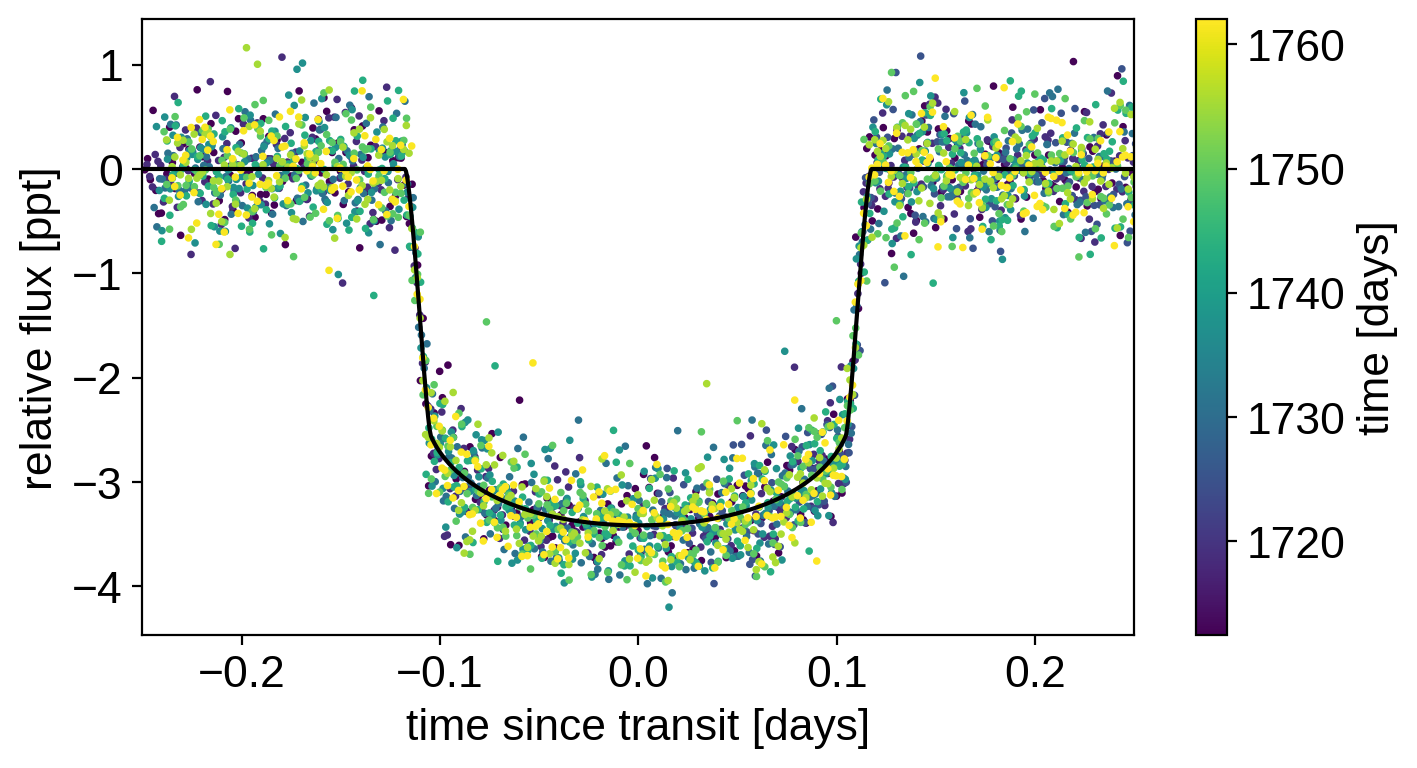

In [7]:
with model:
    gp_pred, lc_pred = xo.eval_in_model([gp.predict(), lc_model(x)], map_soln)

plt.figure(figsize=(8, 4))
x_fold = (x - map_soln["t0"] + 0.5 * map_soln["period"]) % map_soln[
    "period"
] - 0.5 * map_soln["period"]
inds = np.argsort(x_fold)
plt.scatter(x_fold, y - gp_pred - map_soln["mean"], c=x, s=3)
plt.plot(x_fold[inds], lc_pred[inds] - map_soln["mean"], "k")
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
plt.xlim(-0.25, 0.25);

That looks better!

Now on to sampling:

In [8]:
np.random.seed(721)
with model:
    trace = pm.sample(
        tune=2000,
        draws=2000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [b, log_dur, t0, log_period, log_ror, log_w0, log_Sw4, sigma, u, mean]


Sampling 4 chains, 0 divergences:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 21/16000 [00:00<05:18, 50.11draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 25/16000 [00:00<11:21, 23.43draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 29/16000 [00:01<15:31, 17.15draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 33/16000 [00:01<18:25, 14.44draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 37/16000 [00:01<20:27, 13.00draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 41/16000 [00:02<21:52, 12.16draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 45/16000 [00:02<23:10, 11.48draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 49/16000 [00:03<23:50, 11.15draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 53/16000 [00:03<24:17, 10.94draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 57/16000 [00:03<24:36, 10.80draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 61/16000 [00:04<24:49, 10.70draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 66/16000 [00:04<23:27, 11.32draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 69/16000 [00:04<19:09, 13.85draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 71/16000 [00:05<26:40,  9.95draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 74/16000 [00:05<27:58,  9.49draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 78/16000 [00:05<27:10,  9.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 81/16000 [00:05<21:51, 12.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 83/16000 [00:06<27:42,  9.58draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 86/16000 [00:06<28:30,  9.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 90/16000 [00:06<22:27, 11.80draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 92/16000 [00:06<28:14,  9.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 95/16000 [00:07<28:18,  9.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 98/16000 [00:07<22:59, 11.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 100/16000 [00:07<26:28, 10.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 102/16000 [00:07<23:20, 11.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 104/16000 [00:08<26:41,  9.92draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 106/16000 [00:08<23:30, 11.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 108/16000 [00:08<26:47,  9.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 110/16000 [00:08<23:44, 11.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 112/16000 [00:08<26:55,  9.84draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 114/16000 [00:08<23:47, 11.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 116/16000 [00:09<27:10,  9.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 118/16000 [00:09<24:00, 11.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 120/16000 [00:09<27:05,  9.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 122/16000 [00:09<23:58, 11.04draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 124/16000 [00:10<26:56,  9.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 126/16000 [00:10<23:59, 11.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 128/16000 [00:10<27:07,  9.75draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 130/16000 [00:10<24:46, 10.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 132/16000 [00:10<26:42,  9.90draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 134/16000 [00:10<24:37, 10.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 136/16000 [00:11<26:34,  9.95draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 138/16000 [00:11<25:12, 10.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 140/16000 [00:11<26:26, 10.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 142/16000 [00:11<24:52, 10.62draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 144/16000 [00:11<26:11, 10.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 146/16000 [00:12<24:41, 10.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 148/16000 [00:12<26:04, 10.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 150/16000 [00:12<24:49, 10.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 152/16000 [00:12<25:55, 10.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 154/16000 [00:12<24:44, 10.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 156/16000 [00:13<25:50, 10.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 158/16000 [00:13<24:41, 10.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 160/16000 [00:13<26:00, 10.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 162/16000 [00:13<24:36, 10.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 164/16000 [00:13<25:55, 10.18draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 166/16000 [00:13<24:03, 10.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 168/16000 [00:14<21:20, 12.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 170/16000 [00:14<25:38, 10.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 172/16000 [00:14<22:40, 11.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 174/16000 [00:14<20:32, 12.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 176/16000 [00:14<25:08, 10.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 178/16000 [00:14<21:55, 12.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 180/16000 [00:15<26:39,  9.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 182/16000 [00:15<22:38, 11.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 184/16000 [00:15<27:16,  9.66draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 187/16000 [00:15<25:26, 10.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 189/16000 [00:16<25:19, 10.41draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 191/16000 [00:16<26:06, 10.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 193/16000 [00:16<24:59, 10.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 195/16000 [00:16<25:58, 10.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 197/16000 [00:16<24:46, 10.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 199/16000 [00:17<25:54, 10.16draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 201/16000 [00:17<24:39, 10.68draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 203/16000 [00:17<25:54, 10.16draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 205/16000 [00:17<24:32, 10.73draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 207/16000 [00:17<25:56, 10.15draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 209/16000 [00:18<24:59, 10.53draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 211/16000 [00:18<25:48, 10.20draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 213/16000 [00:18<25:08, 10.46draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 215/16000 [00:18<25:39, 10.25draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 217/16000 [00:18<25:17, 10.40draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 219/16000 [00:19<25:48, 10.19draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 221/16000 [00:19<25:21, 10.37draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 223/16000 [00:19<25:37, 10.26draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 225/16000 [00:19<25:26, 10.33draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 227/16000 [00:19<25:26, 10.33draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 229/16000 [00:19<25:27, 10.33draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 231/16000 [00:20<25:19, 10.38draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 233/16000 [00:20<25:15, 10.40draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 235/16000 [00:20<25:17, 10.39draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 237/16000 [00:20<25:20, 10.36draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 239/16000 [00:20<25:13, 10.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 241/16000 [00:21<25:12, 10.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 243/16000 [00:21<25:14, 10.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 245/16000 [00:21<25:06, 10.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 247/16000 [00:21<25:15, 10.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 249/16000 [00:21<25:01, 10.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 251/16000 [00:22<25:18, 10.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 253/16000 [00:22<24:58, 10.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 255/16000 [00:22<25:35, 10.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 257/16000 [00:22<24:49, 10.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 259/16000 [00:22<25:35, 10.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 261/16000 [00:23<24:43, 10.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 264/16000 [00:23<22:50, 11.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 266/16000 [00:23<25:43, 10.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 268/16000 [00:23<23:23, 11.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 270/16000 [00:23<26:00, 10.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 272/16000 [00:24<23:40, 11.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 274/16000 [00:24<21:01, 12.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 276/16000 [00:24<20:27, 12.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 278/16000 [00:24<24:21, 10.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 280/16000 [00:24<22:29, 11.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 282/16000 [00:24<25:19, 10.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 284/16000 [00:25<23:27, 11.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 286/16000 [00:25<25:41, 10.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 288/16000 [00:25<24:02, 10.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 290/16000 [00:25<25:45, 10.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 292/16000 [00:25<24:24, 10.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 294/16000 [00:26<25:42, 10.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 296/16000 [00:26<24:41, 10.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 298/16000 [00:26<25:34, 10.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 300/16000 [00:26<24:55, 10.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 302/16000 [00:26<25:24, 10.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 304/16000 [00:27<25:07, 10.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 306/16000 [00:27<25:14, 10.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 308/16000 [00:27<25:18, 10.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 310/16000 [00:27<25:02, 10.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 312/16000 [00:27<25:38, 10.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 314/16000 [00:27<24:54, 10.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 316/16000 [00:28<25:46, 10.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 318/16000 [00:28<24:39, 10.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 320/16000 [00:28<26:09,  9.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 322/16000 [00:28<24:22, 10.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 324/16000 [00:28<26:16,  9.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 326/16000 [00:29<24:07, 10.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 328/16000 [00:29<26:25,  9.89draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 330/16000 [00:29<23:54, 10.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 332/16000 [00:29<26:34,  9.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 334/16000 [00:29<23:42, 11.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 336/16000 [00:30<26:45,  9.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 338/16000 [00:30<24:17, 10.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 340/16000 [00:30<26:50,  9.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 342/16000 [00:30<23:53, 10.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 344/16000 [00:30<26:52,  9.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 346/16000 [00:31<23:35, 11.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 348/16000 [00:31<26:59,  9.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 350/16000 [00:31<23:20, 11.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 352/16000 [00:31<27:06,  9.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 354/16000 [00:31<23:08, 11.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 356/16000 [00:32<27:16,  9.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 359/16000 [00:32<24:16, 10.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 361/16000 [00:32<25:14, 10.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 363/16000 [00:32<24:19, 10.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 365/16000 [00:32<25:22, 10.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 367/16000 [00:33<24:32, 10.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 369/16000 [00:33<25:23, 10.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 371/16000 [00:33<24:28, 10.64draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 373/16000 [00:33<25:23, 10.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 375/16000 [00:33<24:25, 10.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 377/16000 [00:34<25:34, 10.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 379/16000 [00:34<24:19, 10.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 381/16000 [00:34<25:48, 10.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 383/16000 [00:34<24:11, 10.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 385/16000 [00:34<26:01, 10.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 387/16000 [00:34<24:02, 10.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 389/16000 [00:35<26:28,  9.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 391/16000 [00:35<23:46, 10.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 393/16000 [00:35<26:35,  9.78draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 395/16000 [00:35<23:33, 11.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 397/16000 [00:35<26:44,  9.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 399/16000 [00:36<23:21, 11.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 401/16000 [00:36<26:54,  9.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 403/16000 [00:36<23:09, 11.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 405/16000 [00:36<27:00,  9.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 407/16000 [00:36<22:59, 11.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 409/16000 [00:37<27:07,  9.58draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 412/16000 [00:37<27:36,  9.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 415/16000 [00:37<23:09, 11.21draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 417/16000 [00:37<27:15,  9.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 420/16000 [00:38<27:47,  9.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 423/16000 [00:38<23:11, 11.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 425/16000 [00:38<27:17,  9.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 428/16000 [00:39<27:53,  9.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 431/16000 [00:39<23:09, 11.21draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 433/16000 [00:39<27:16,  9.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 436/16000 [00:39<27:58,  9.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 438/16000 [00:39<23:49, 10.89draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 440/16000 [00:40<27:20,  9.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 442/16000 [00:40<24:21, 10.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 444/16000 [00:40<26:44,  9.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 446/16000 [00:40<23:51, 10.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 448/16000 [00:40<26:27,  9.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 450/16000 [00:41<23:35, 10.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 452/16000 [00:41<26:20,  9.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 454/16000 [00:41<23:26, 11.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 456/16000 [00:41<26:18,  9.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 458/16000 [00:41<23:20, 11.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 460/16000 [00:42<26:18,  9.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 462/16000 [00:42<23:30, 11.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 464/16000 [00:42<26:14,  9.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 466/16000 [00:42<23:23, 11.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 468/16000 [00:42<26:24,  9.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 470/16000 [00:42<23:15, 11.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 472/16000 [00:43<26:23,  9.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 474/16000 [00:43<23:10, 11.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 476/16000 [00:43<26:23,  9.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 478/16000 [00:43<23:06, 11.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 480/16000 [00:44<26:24,  9.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 482/16000 [00:44<23:02, 11.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 484/16000 [00:44<26:26,  9.78draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 486/16000 [00:44<23:00, 11.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 488/16000 [00:44<26:27,  9.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 490/16000 [00:44<22:56, 11.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 492/16000 [00:45<26:31,  9.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 494/16000 [00:45<22:53, 11.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 496/16000 [00:45<26:32,  9.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 498/16000 [00:45<22:50, 11.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 500/16000 [00:45<26:34,  9.72draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 502/16000 [00:46<22:47, 11.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 504/16000 [00:46<26:36,  9.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 506/16000 [00:46<22:44, 11.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 508/16000 [00:46<26:52,  9.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 511/16000 [00:46<25:40, 10.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 513/16000 [00:47<22:38, 11.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 515/16000 [00:47<26:15,  9.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 517/16000 [00:47<22:43, 11.35draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 519/16000 [00:47<26:37,  9.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 521/16000 [00:47<22:42, 11.36draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 523/16000 [00:48<26:53,  9.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 526/16000 [00:48<23:41, 10.88draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 528/16000 [00:48<27:46,  9.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 531/16000 [00:48<27:11,  9.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 534/16000 [00:49<23:28, 10.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 536/16000 [00:49<27:38,  9.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 539/16000 [00:49<27:30,  9.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 542/16000 [00:49<23:16, 11.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 544/16000 [00:50<27:30,  9.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 547/16000 [00:50<27:49,  9.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 550/16000 [00:50<23:04, 11.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 552/16000 [00:50<27:23,  9.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 555/16000 [00:51<28:08,  9.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 558/16000 [00:51<22:51, 11.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 560/16000 [00:51<27:16,  9.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 563/16000 [00:52<28:27,  9.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 566/16000 [00:52<22:39, 11.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 568/16000 [00:52<27:09,  9.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 571/16000 [00:52<28:53,  8.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 574/16000 [00:52<22:55, 11.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 576/16000 [00:53<27:00,  9.52draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 579/16000 [00:53<28:30,  9.01draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 582/16000 [00:53<22:39, 11.34draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 584/16000 [00:53<26:31,  9.69draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 586/16000 [00:54<22:36, 11.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 589/16000 [00:54<18:43, 13.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 592/16000 [00:54<15:44, 16.31draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 595/16000 [00:54<18:13, 14.09draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 597/16000 [00:54<16:37, 15.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 600/16000 [00:54<14:14, 18.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 603/16000 [00:54<13:29, 19.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 606/16000 [00:55<14:21, 17.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 612/16000 [00:55<11:26, 22.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 617/16000 [00:55<10:13, 25.09draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 621/16000 [00:55<10:02, 25.53draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 629/16000 [00:55<08:24, 30.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 633/16000 [00:55<08:26, 30.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 638/16000 [00:55<07:29, 34.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 648/16000 [00:55<06:01, 42.43draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 654/16000 [00:56<05:42, 44.82draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 661/16000 [00:56<05:14, 48.82draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 672/16000 [00:56<04:30, 56.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 679/16000 [00:56<04:20, 58.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 688/16000 [00:56<03:58, 64.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 698/16000 [00:56<03:37, 70.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 710/16000 [00:56<03:13, 78.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 721/16000 [00:56<03:01, 84.17draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 733/16000 [00:56<02:46, 91.72draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 747/16000 [00:57<02:30, 101.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 763/16000 [00:57<02:16, 111.37draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 779/16000 [00:57<02:05, 121.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 795/16000 [00:57<01:57, 129.43draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 814/16000 [00:57<01:48, 139.56draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 834/16000 [00:57<01:41, 149.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 853/16000 [00:57<01:35, 158.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 870/16000 [00:57<01:35, 157.62draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 887/16000 [00:57<01:35, 157.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 904/16000 [00:58<01:35, 157.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 920/16000 [00:58<01:37, 154.33draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 936/16000 [00:58<01:38, 152.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 954/16000 [00:58<01:34, 159.23draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 973/16000 [00:58<01:30, 165.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 991/16000 [00:58<01:29, 167.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1010/16000 [00:58<01:26, 173.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1029/16000 [00:58<01:24, 177.79draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1048/16000 [00:58<01:25, 175.56draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1069/16000 [00:58<01:21, 184.00draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1089/16000 [00:59<01:21, 182.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1109/16000 [00:59<01:20, 185.18draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1132/16000 [00:59<01:16, 193.98draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1152/16000 [00:59<01:15, 195.73draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1175/16000 [00:59<01:12, 204.71draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1198/16000 [00:59<01:11, 208.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1221/16000 [00:59<01:09, 213.35draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1243/16000 [00:59<01:10, 209.67draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1267/16000 [00:59<01:08, 213.80draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1292/16000 [01:00<01:06, 222.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1316/16000 [01:00<01:05, 225.44draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1339/16000 [01:00<01:06, 220.83draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1362/16000 [01:00<01:10, 208.81draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1384/16000 [01:00<01:11, 205.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1406/16000 [01:00<01:11, 204.12draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1433/16000 [01:00<01:06, 218.38draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1456/16000 [01:00<01:06, 219.25draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1479/16000 [01:00<01:09, 209.33draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1501/16000 [01:01<01:13, 198.02draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1522/16000 [01:01<01:15, 191.12draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1545/16000 [01:01<01:12, 198.60draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1570/16000 [01:01<01:08, 211.21draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1596/16000 [01:01<01:04, 223.59draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1619/16000 [01:01<01:08, 210.33draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1641/16000 [01:01<01:08, 210.04draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1663/16000 [01:01<01:07, 211.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1686/16000 [01:01<01:07, 213.41draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1708/16000 [01:02<01:06, 215.09draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1731/16000 [01:02<01:05, 219.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1755/16000 [01:02<01:05, 218.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1778/16000 [01:02<01:04, 221.21draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1801/16000 [01:02<01:04, 221.33draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1829/16000 [01:02<01:00, 234.86draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1855/16000 [01:02<00:59, 239.26draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1880/16000 [01:02<00:58, 239.99draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1905/16000 [01:02<01:00, 232.58draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1929/16000 [01:02<01:01, 227.53draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1952/16000 [01:03<01:04, 219.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1980/16000 [01:03<01:00, 232.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2004/16000 [01:03<01:06, 210.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2026/16000 [01:03<01:07, 206.71draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2050/16000 [01:03<01:05, 214.35draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2074/16000 [01:03<01:03, 217.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2097/16000 [01:03<01:03, 219.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2123/16000 [01:03<01:00, 227.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2146/16000 [01:03<01:03, 219.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2169/16000 [01:04<01:03, 218.20draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2191/16000 [01:04<01:04, 212.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2213/16000 [01:04<01:06, 208.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2234/16000 [01:04<01:07, 203.44draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2256/16000 [01:04<01:06, 205.72draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2277/16000 [01:04<01:06, 206.98draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2298/16000 [01:04<01:06, 207.44draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2319/16000 [01:04<01:07, 202.47draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2340/16000 [01:04<01:07, 201.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2361/16000 [01:05<01:08, 197.70draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2384/16000 [01:05<01:06, 205.95draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2405/16000 [01:05<01:07, 201.56draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2426/16000 [01:05<01:06, 203.65draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2447/16000 [01:05<01:07, 202.18draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2469/16000 [01:05<01:06, 204.65draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2490/16000 [01:05<01:08, 198.61draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2510/16000 [01:05<01:08, 197.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2530/16000 [01:05<01:11, 188.29draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2549/16000 [01:05<01:11, 188.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2573/16000 [01:06<01:07, 199.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2596/16000 [01:06<01:04, 207.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2617/16000 [01:06<01:06, 202.25draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2638/16000 [01:06<01:07, 198.45draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2658/16000 [01:06<01:07, 196.48draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2681/16000 [01:06<01:05, 203.85draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2706/16000 [01:06<01:02, 214.01draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2730/16000 [01:06<01:00, 221.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2753/16000 [01:06<01:02, 212.36draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2775/16000 [01:07<01:04, 204.40draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2796/16000 [01:07<01:05, 200.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2818/16000 [01:07<01:05, 200.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2839/16000 [01:07<01:07, 194.20draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2860/16000 [01:07<01:08, 190.76draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2881/16000 [01:07<01:09, 187.61draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2902/16000 [01:07<01:09, 188.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2921/16000 [01:07<01:11, 181.87draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2940/16000 [01:07<01:13, 176.94draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2958/16000 [01:08<01:16, 169.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2976/16000 [01:08<01:17, 168.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2994/16000 [01:08<01:17, 167.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3014/16000 [01:08<01:13, 175.76draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3033/16000 [01:08<01:14, 174.85draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3054/16000 [01:08<01:11, 182.24draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3076/16000 [01:08<01:07, 190.49draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3096/16000 [01:08<01:09, 185.75draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3117/16000 [01:08<01:07, 191.62draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3137/16000 [01:09<01:11, 180.08draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3156/16000 [01:09<01:11, 178.92draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3177/16000 [01:09<01:08, 187.20draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3196/16000 [01:09<01:08, 187.55draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3216/16000 [01:09<01:07, 189.59draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3236/16000 [01:09<01:07, 188.19draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3255/16000 [01:09<01:11, 179.40draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3274/16000 [01:09<01:15, 169.30draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3293/16000 [01:09<01:14, 170.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3314/16000 [01:10<01:10, 179.63draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3334/16000 [01:10<01:09, 183.34draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3353/16000 [01:10<01:08, 183.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3375/16000 [01:10<01:07, 188.41draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3397/16000 [01:10<01:06, 189.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3417/16000 [01:10<01:10, 179.13draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3438/16000 [01:10<01:09, 181.84draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3462/16000 [01:10<01:04, 193.17draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3485/16000 [01:10<01:02, 201.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3507/16000 [01:11<01:02, 199.56draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3528/16000 [01:11<01:04, 192.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3549/16000 [01:11<01:03, 196.86draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3569/16000 [01:11<01:03, 194.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3589/16000 [01:11<01:05, 188.16draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3608/16000 [01:11<01:06, 186.28draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3627/16000 [01:11<01:07, 183.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3646/16000 [01:11<01:07, 184.06draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3665/16000 [01:11<01:08, 180.74draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3684/16000 [01:12<01:10, 174.24draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3703/16000 [01:12<01:09, 176.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3722/16000 [01:12<01:08, 178.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3740/16000 [01:12<01:10, 174.28draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3758/16000 [01:12<01:10, 174.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3776/16000 [01:12<01:10, 174.52draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3795/16000 [01:12<01:09, 175.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3815/16000 [01:12<01:06, 182.02draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3837/16000 [01:12<01:05, 184.80draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3859/16000 [01:12<01:02, 194.09draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3879/16000 [01:13<01:06, 182.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3898/16000 [01:13<01:07, 179.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3917/16000 [01:13<01:06, 180.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3936/16000 [01:13<01:07, 178.43draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3954/16000 [01:13<01:08, 175.86draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3974/16000 [01:13<01:06, 181.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3993/16000 [01:13<01:06, 181.71draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4012/16000 [01:13<01:08, 173.76draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4034/16000 [01:13<01:06, 178.76draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4052/16000 [01:14<01:06, 178.82draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4070/16000 [01:14<01:07, 176.50draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4090/16000 [01:14<01:05, 181.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4109/16000 [01:14<01:06, 178.26draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4129/16000 [01:14<01:05, 181.01draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4148/16000 [01:14<01:09, 169.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4168/16000 [01:14<01:07, 176.13draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4186/16000 [01:14<01:07, 176.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4210/16000 [01:14<01:01, 190.32draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4230/16000 [01:15<01:01, 190.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4250/16000 [01:15<01:03, 186.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4269/16000 [01:15<01:04, 182.43draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4289/16000 [01:15<01:02, 186.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4308/16000 [01:15<01:04, 181.58draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4327/16000 [01:15<01:07, 173.44draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4346/16000 [01:15<01:06, 174.39draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4365/16000 [01:15<01:06, 176.28draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4383/16000 [01:15<01:06, 175.79draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4401/16000 [01:15<01:06, 174.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4419/16000 [01:16<01:08, 169.58draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4440/16000 [01:16<01:04, 179.54draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4460/16000 [01:16<01:02, 183.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4480/16000 [01:16<01:02, 184.22draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4499/16000 [01:16<01:02, 183.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4518/16000 [01:16<01:03, 180.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4537/16000 [01:16<01:04, 178.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4558/16000 [01:16<01:01, 185.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4577/16000 [01:16<01:01, 186.66draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4596/16000 [01:17<01:00, 187.41draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4615/16000 [01:17<01:03, 180.52draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4634/16000 [01:17<01:04, 176.61draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4655/16000 [01:17<01:01, 183.03draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4675/16000 [01:17<01:00, 186.85draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4694/16000 [01:17<01:03, 178.90draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4713/16000 [01:17<01:03, 177.53draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4737/16000 [01:17<00:59, 187.82draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4764/16000 [01:17<00:55, 201.15draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4786/16000 [01:18<00:55, 201.85draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4807/16000 [01:18<00:56, 197.70draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4827/16000 [01:18<00:57, 194.30draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4847/16000 [01:18<00:59, 186.78draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4866/16000 [01:18<01:00, 183.96draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4885/16000 [01:18<01:00, 183.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4905/16000 [01:18<01:00, 183.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4925/16000 [01:18<00:58, 187.74draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4948/16000 [01:18<00:57, 192.75draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4968/16000 [01:18<00:57, 192.91draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4988/16000 [01:19<00:58, 188.81draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5012/16000 [01:19<00:55, 198.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5032/16000 [01:19<00:56, 193.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5052/16000 [01:19<00:59, 184.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5071/16000 [01:19<01:01, 177.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5089/16000 [01:19<01:01, 176.10draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5110/16000 [01:19<00:59, 183.36draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5129/16000 [01:19<00:59, 183.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5148/16000 [01:19<01:01, 177.16draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5166/16000 [01:20<01:01, 176.28draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5184/16000 [01:20<01:02, 173.68draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5203/16000 [01:20<01:01, 176.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5222/16000 [01:20<00:59, 179.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5244/16000 [01:20<00:57, 185.85draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5263/16000 [01:20<00:59, 181.97draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5283/16000 [01:20<00:57, 186.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5303/16000 [01:20<00:56, 187.67draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5327/16000 [01:20<00:54, 196.36draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5351/16000 [01:21<00:52, 202.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 5375/16000 [01:21<00:51, 207.23draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 5398/16000 [01:21<00:49, 213.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5420/16000 [01:21<00:52, 202.12draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5441/16000 [01:21<00:52, 199.30draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5462/16000 [01:21<00:55, 190.35draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5482/16000 [01:21<00:55, 189.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5505/16000 [01:21<00:54, 193.78draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5525/16000 [01:21<00:54, 191.64draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5548/16000 [01:22<00:52, 199.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5569/16000 [01:22<00:51, 202.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5590/16000 [01:22<00:52, 196.76draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5613/16000 [01:22<00:51, 203.34draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5634/16000 [01:22<00:53, 193.17draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5654/16000 [01:22<00:54, 190.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5676/16000 [01:22<00:52, 196.80draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5697/16000 [01:22<00:51, 198.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5717/16000 [01:22<00:52, 194.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5739/16000 [01:23<00:51, 199.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5760/16000 [01:23<00:53, 189.83draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5780/16000 [01:23<00:53, 190.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5800/16000 [01:23<00:55, 184.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5821/16000 [01:23<00:53, 190.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5841/16000 [01:23<00:54, 187.38draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5860/16000 [01:23<00:54, 186.46draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5881/16000 [01:23<00:53, 190.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5901/16000 [01:23<00:52, 192.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5923/16000 [01:23<00:50, 197.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5946/16000 [01:24<00:49, 202.78draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5967/16000 [01:24<00:50, 198.32draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5989/16000 [01:24<00:49, 202.52draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6011/16000 [01:24<00:49, 203.73draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6035/16000 [01:24<00:48, 206.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6056/16000 [01:24<00:48, 204.66draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6080/16000 [01:24<00:46, 213.89draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6104/16000 [01:24<00:45, 215.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6130/16000 [01:24<00:44, 223.05draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6156/16000 [01:25<00:42, 232.25draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6180/16000 [01:25<00:42, 229.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6204/16000 [01:25<00:45, 217.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6226/16000 [01:25<00:44, 218.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6248/16000 [01:25<00:46, 211.28draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6270/16000 [01:25<00:48, 199.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6291/16000 [01:25<00:48, 199.47draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6312/16000 [01:25<00:49, 195.88draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6332/16000 [01:25<00:51, 186.85draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6351/16000 [01:26<00:54, 177.81draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6372/16000 [01:26<00:52, 184.56draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6392/16000 [01:26<00:51, 185.50draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6411/16000 [01:26<00:51, 185.86draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6430/16000 [01:26<00:54, 176.11draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6448/16000 [01:26<00:54, 176.70draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6468/16000 [01:26<00:52, 180.76draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6490/16000 [01:26<00:50, 188.25draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6509/16000 [01:26<00:50, 188.24draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6532/16000 [01:27<00:47, 197.73draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6552/16000 [01:27<00:50, 188.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6573/16000 [01:27<00:49, 191.41draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6593/16000 [01:27<00:48, 192.35draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 6613/16000 [01:27<00:50, 186.89draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 6632/16000 [01:27<00:50, 185.41draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6651/16000 [01:27<00:50, 185.67draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6670/16000 [01:27<00:51, 180.55draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6689/16000 [01:27<00:51, 182.24draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6708/16000 [01:27<00:50, 182.26draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6727/16000 [01:28<00:50, 181.86draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6746/16000 [01:28<00:50, 183.73draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6765/16000 [01:28<00:50, 183.02draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6784/16000 [01:28<00:49, 184.45draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6805/16000 [01:28<00:48, 189.53draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6824/16000 [01:28<00:48, 188.47draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6845/16000 [01:28<00:47, 192.23draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6865/16000 [01:28<00:50, 181.25draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6885/16000 [01:28<00:49, 182.61draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6904/16000 [01:29<00:50, 178.87draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6924/16000 [01:29<00:50, 179.73draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6943/16000 [01:29<00:50, 180.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6962/16000 [01:29<00:49, 182.21draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6983/16000 [01:29<00:48, 187.56draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7004/16000 [01:29<00:46, 192.38draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7027/16000 [01:29<00:44, 200.58draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7048/16000 [01:29<00:46, 190.75draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7070/16000 [01:29<00:45, 194.88draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7093/16000 [01:29<00:43, 203.53draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7114/16000 [01:30<00:44, 200.48draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7135/16000 [01:30<00:46, 191.28draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7155/16000 [01:30<00:49, 179.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7175/16000 [01:30<00:48, 183.61draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7194/16000 [01:30<00:48, 183.28draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7213/16000 [01:30<00:47, 183.88draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7233/16000 [01:30<00:47, 182.82draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7252/16000 [01:30<00:47, 183.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7271/16000 [01:30<00:47, 184.27draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7290/16000 [01:31<00:47, 184.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7309/16000 [01:31<00:48, 179.13draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7327/16000 [01:31<00:48, 179.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7345/16000 [01:31<00:48, 179.17draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7363/16000 [01:31<00:48, 179.12draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7382/16000 [01:31<00:47, 181.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 7401/16000 [01:31<00:49, 173.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 7419/16000 [01:31<00:51, 165.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 7437/16000 [01:31<00:50, 169.03draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7455/16000 [01:32<00:51, 166.97draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7473/16000 [01:32<00:51, 164.46draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7493/16000 [01:32<00:49, 171.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7511/16000 [01:32<00:49, 172.97draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7529/16000 [01:32<00:51, 165.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7548/16000 [01:32<00:49, 169.57draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7570/16000 [01:32<00:47, 178.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7590/16000 [01:32<00:45, 184.43draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7612/16000 [01:32<00:44, 190.42draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7634/16000 [01:33<00:42, 196.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7654/16000 [01:33<00:43, 192.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7676/16000 [01:33<00:42, 197.85draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7698/16000 [01:33<00:41, 198.68draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7719/16000 [01:33<00:41, 199.56draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7740/16000 [01:33<00:41, 201.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 7761/16000 [01:33<00:43, 190.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 7783/16000 [01:33<00:41, 197.53draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7803/16000 [01:33<00:43, 187.02draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7823/16000 [01:33<00:43, 188.94draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7843/16000 [01:34<00:43, 188.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7863/16000 [01:34<00:43, 188.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7882/16000 [01:34<00:43, 187.13draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7901/16000 [01:34<00:43, 186.79draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7920/16000 [01:34<00:44, 181.00draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7939/16000 [01:34<00:44, 181.07draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7960/16000 [01:34<00:43, 184.21draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7980/16000 [01:34<00:43, 183.77draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7999/16000 [01:34<00:43, 182.64draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8018/16000 [01:35<00:44, 178.04draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8038/16000 [01:35<00:45, 174.32draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8058/16000 [01:35<00:44, 177.29draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8078/16000 [01:35<00:43, 182.00draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8097/16000 [01:35<00:45, 175.50draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8116/16000 [01:35<00:44, 175.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8134/16000 [01:35<00:45, 174.15draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8152/16000 [01:35<00:44, 175.59draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8173/16000 [01:35<00:42, 182.85draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8192/16000 [01:36<00:42, 182.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 8212/16000 [01:36<00:42, 182.59draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 8233/16000 [01:36<00:42, 184.46draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8252/16000 [01:36<00:41, 185.85draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8271/16000 [01:36<00:43, 178.65draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8290/16000 [01:36<00:43, 179.07draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8311/16000 [01:36<00:41, 186.38draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8331/16000 [01:36<00:41, 186.98draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8351/16000 [01:36<00:41, 185.45draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8370/16000 [01:37<00:41, 181.96draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8389/16000 [01:37<00:42, 180.93draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8408/16000 [01:37<00:42, 179.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8428/16000 [01:37<00:41, 180.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8448/16000 [01:37<00:41, 180.22draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8467/16000 [01:37<00:42, 179.14draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8486/16000 [01:37<00:41, 179.18draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8504/16000 [01:37<00:41, 178.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8525/16000 [01:37<00:40, 184.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8544/16000 [01:37<00:40, 182.65draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 8563/16000 [01:38<00:40, 183.29draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 8582/16000 [01:38<00:41, 177.14draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8602/16000 [01:38<00:41, 179.27draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8620/16000 [01:38<00:41, 178.22draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8640/16000 [01:38<00:40, 182.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8659/16000 [01:38<00:40, 180.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8679/16000 [01:38<00:39, 183.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8701/16000 [01:38<00:37, 192.81draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8721/16000 [01:38<00:38, 189.93draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8741/16000 [01:39<00:38, 190.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8761/16000 [01:39<00:38, 187.22draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8780/16000 [01:39<00:39, 182.84draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8800/16000 [01:39<00:39, 183.22draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8819/16000 [01:39<00:39, 180.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8838/16000 [01:39<00:39, 179.63draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8858/16000 [01:39<00:39, 181.57draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8877/16000 [01:39<00:39, 178.74draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8897/16000 [01:39<00:39, 179.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8916/16000 [01:40<00:38, 182.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8935/16000 [01:40<00:38, 182.03draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8954/16000 [01:40<00:39, 179.61draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8972/16000 [01:40<00:40, 173.55draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8990/16000 [01:40<00:40, 174.29draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 9009/16000 [01:40<00:39, 178.62draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 9028/16000 [01:40<00:39, 177.33draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9046/16000 [01:40<00:39, 177.57draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9065/16000 [01:40<00:38, 180.55draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9084/16000 [01:40<00:38, 179.56draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9104/16000 [01:41<00:37, 184.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9123/16000 [01:41<00:37, 183.53draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9142/16000 [01:41<00:38, 178.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9161/16000 [01:41<00:37, 180.01draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9180/16000 [01:41<00:38, 178.83draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9198/16000 [01:41<00:38, 177.95draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9216/16000 [01:41<00:38, 174.91draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9235/16000 [01:41<00:38, 174.41draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9254/16000 [01:41<00:38, 174.58draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9275/16000 [01:42<00:37, 181.08draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9296/16000 [01:42<00:36, 182.52draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9315/16000 [01:42<00:36, 181.95draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9334/16000 [01:42<00:37, 179.65draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9352/16000 [01:42<00:37, 176.56draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 9371/16000 [01:42<00:37, 174.88draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 9393/16000 [01:42<00:36, 181.94draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9412/16000 [01:42<00:36, 179.06draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9432/16000 [01:42<00:35, 184.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9451/16000 [01:42<00:36, 178.60draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9469/16000 [01:43<00:37, 174.71draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9488/16000 [01:43<00:36, 177.05draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9506/16000 [01:43<00:36, 176.30draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9524/16000 [01:43<00:37, 174.73draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9544/16000 [01:43<00:36, 176.97draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9563/16000 [01:43<00:36, 177.60draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9581/16000 [01:43<00:37, 173.05draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9599/16000 [01:43<00:37, 172.57draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 9619/16000 [01:43<00:35, 178.43draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 9637/16000 [01:44<00:36, 174.16draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 9657/16000 [01:44<00:37, 171.36draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 9676/16000 [01:44<00:35, 176.16draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9695/16000 [01:44<00:35, 177.57draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9713/16000 [01:44<00:35, 176.11draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9731/16000 [01:44<00:35, 176.21draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9750/16000 [01:44<00:35, 176.46draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9769/16000 [01:44<00:35, 175.96draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9788/16000 [01:44<00:34, 179.21draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 9806/16000 [01:45<00:34, 177.51draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 9824/16000 [01:45<00:34, 177.64draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9845/16000 [01:45<00:33, 185.50draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9865/16000 [01:45<00:32, 187.79draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9884/16000 [01:45<00:33, 183.65draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9903/16000 [01:45<00:33, 180.88draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9922/16000 [01:45<00:34, 175.94draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9940/16000 [01:45<00:34, 175.58draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9958/16000 [01:45<00:34, 176.00draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9976/16000 [01:45<00:35, 171.78draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9996/16000 [01:46<00:34, 176.44draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10017/16000 [01:46<00:32, 185.05draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10036/16000 [01:46<00:33, 177.86draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10055/16000 [01:46<00:33, 177.00draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10074/16000 [01:46<00:32, 180.31draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10093/16000 [01:46<00:33, 178.33draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10112/16000 [01:46<00:32, 178.44draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10130/16000 [01:46<00:33, 176.49draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10150/16000 [01:46<00:32, 181.14draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 10169/16000 [01:47<00:31, 182.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 10190/16000 [01:47<00:31, 184.02draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10209/16000 [01:47<00:31, 185.39draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10228/16000 [01:47<00:31, 184.52draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10247/16000 [01:47<00:31, 181.70draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10269/16000 [01:47<00:30, 187.47draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10290/16000 [01:47<00:30, 189.31draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10309/16000 [01:47<00:30, 184.05draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 10328/16000 [01:47<00:31, 180.30draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 10349/16000 [01:47<00:30, 186.00draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 10368/16000 [01:48<00:30, 186.77draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 10387/16000 [01:48<00:30, 183.26draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 10408/16000 [01:48<00:29, 188.49draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 10427/16000 [01:48<00:30, 183.99draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 10446/16000 [01:48<00:29, 185.58draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 10465/16000 [01:48<00:31, 178.50draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10483/16000 [01:48<00:31, 176.88draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10503/16000 [01:48<00:30, 182.71draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10522/16000 [01:48<00:29, 184.47draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10541/16000 [01:49<00:29, 184.73draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10561/16000 [01:49<00:28, 187.85draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10580/16000 [01:49<00:28, 187.03draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 10600/16000 [01:49<00:28, 186.21draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 10619/16000 [01:49<00:28, 186.11draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 10638/16000 [01:49<00:28, 185.85draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10657/16000 [01:49<00:28, 185.28draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10676/16000 [01:49<00:29, 179.58draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10696/16000 [01:49<00:28, 184.98draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10715/16000 [01:49<00:29, 176.57draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10733/16000 [01:50<00:29, 176.35draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10752/16000 [01:50<00:30, 174.22draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10772/16000 [01:50<00:29, 177.38draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10790/16000 [01:50<00:29, 177.60draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10810/16000 [01:50<00:28, 181.98draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10829/16000 [01:50<00:28, 181.72draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10848/16000 [01:50<00:28, 183.83draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10867/16000 [01:50<00:28, 181.40draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10886/16000 [01:50<00:28, 179.35draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10904/16000 [01:51<00:28, 177.72draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10922/16000 [01:51<00:29, 173.81draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10940/16000 [01:51<00:29, 170.24draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10959/16000 [01:51<00:29, 172.45draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 10978/16000 [01:51<00:28, 176.26draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 10997/16000 [01:51<00:29, 172.08draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11017/16000 [01:51<00:27, 178.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11035/16000 [01:51<00:28, 174.52draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11053/16000 [01:51<00:28, 174.53draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11073/16000 [01:52<00:27, 177.76draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11092/16000 [01:52<00:27, 179.27draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11110/16000 [01:52<00:27, 175.21draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 11128/16000 [01:52<00:27, 175.79draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 11147/16000 [01:52<00:27, 178.97draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 11165/16000 [01:52<00:27, 176.92draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 11185/16000 [01:52<00:26, 181.18draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 11204/16000 [01:52<00:26, 181.45draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 11223/16000 [01:52<00:26, 179.50draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 11242/16000 [01:52<00:26, 181.85draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 11261/16000 [01:53<00:26, 178.56draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 11279/16000 [01:53<00:26, 178.47draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11298/16000 [01:53<00:26, 180.60draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11317/16000 [01:53<00:25, 181.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11336/16000 [01:53<00:25, 182.60draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11355/16000 [01:53<00:25, 183.98draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11374/16000 [01:53<00:25, 183.45draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11393/16000 [01:53<00:25, 180.70draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 11412/16000 [01:53<00:25, 179.66draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 11431/16000 [01:54<00:25, 177.24draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11450/16000 [01:54<00:25, 177.94draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11469/16000 [01:54<00:25, 180.73draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11488/16000 [01:54<00:24, 181.61draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11507/16000 [01:54<00:25, 177.21draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11527/16000 [01:54<00:24, 181.78draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11546/16000 [01:54<00:25, 177.20draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11567/16000 [01:54<00:24, 181.20draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11586/16000 [01:54<00:24, 180.20draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11605/16000 [01:54<00:24, 181.72draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11624/16000 [01:55<00:24, 181.91draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11643/16000 [01:55<00:24, 177.41draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11661/16000 [01:55<00:24, 176.03draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11679/16000 [01:55<00:24, 176.93draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11697/16000 [01:55<00:24, 175.23draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11717/16000 [01:55<00:24, 176.30draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11735/16000 [01:55<00:24, 177.14draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11753/16000 [01:55<00:23, 176.99draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 11772/16000 [01:55<00:24, 175.40draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 11792/16000 [01:56<00:23, 175.99draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11811/16000 [01:56<00:23, 177.60draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11830/16000 [01:56<00:23, 177.48draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11850/16000 [01:56<00:22, 183.01draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11869/16000 [01:56<00:22, 180.62draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11888/16000 [01:56<00:22, 180.69draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11907/16000 [01:56<00:22, 179.89draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 11926/16000 [01:56<00:22, 177.64draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 11945/16000 [01:56<00:22, 181.05draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 11964/16000 [01:56<00:22, 179.33draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 11982/16000 [01:57<00:23, 173.75draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 12002/16000 [01:57<00:22, 175.41draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 12022/16000 [01:57<00:21, 181.20draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 12041/16000 [01:57<00:21, 182.20draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 12060/16000 [01:57<00:21, 180.07draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12081/16000 [01:57<00:21, 183.85draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12100/16000 [01:57<00:21, 183.99draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12119/16000 [01:57<00:20, 184.93draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12139/16000 [01:57<00:21, 183.56draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12162/16000 [01:58<00:20, 191.85draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12182/16000 [01:58<00:20, 186.53draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 12203/16000 [01:58<00:20, 187.43draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 12222/16000 [01:58<00:20, 185.63draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12241/16000 [01:58<00:20, 186.63draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12260/16000 [01:58<00:20, 182.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12279/16000 [01:58<00:20, 182.88draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12298/16000 [01:58<00:20, 179.36draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12317/16000 [01:58<00:20, 182.33draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12336/16000 [01:59<00:20, 179.90draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12355/16000 [01:59<00:20, 181.80draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12374/16000 [01:59<00:20, 179.82draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12393/16000 [01:59<00:19, 181.20draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12412/16000 [01:59<00:19, 182.75draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12431/16000 [01:59<00:19, 184.03draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12451/16000 [01:59<00:19, 183.62draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12471/16000 [01:59<00:19, 182.12draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12490/16000 [01:59<00:19, 182.80draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12510/16000 [01:59<00:18, 185.53draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12529/16000 [02:00<00:18, 183.26draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12548/16000 [02:00<00:19, 177.15draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 12569/16000 [02:00<00:18, 182.81draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 12588/16000 [02:00<00:18, 182.26draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12608/16000 [02:00<00:18, 183.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12627/16000 [02:00<00:18, 181.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12646/16000 [02:00<00:18, 178.79draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12664/16000 [02:00<00:19, 175.01draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12685/16000 [02:00<00:18, 183.85draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12707/16000 [02:01<00:17, 191.12draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 12727/16000 [02:01<00:17, 183.88draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 12748/16000 [02:01<00:17, 185.54draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 12767/16000 [02:01<00:17, 182.54draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 12787/16000 [02:01<00:17, 186.75draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 12806/16000 [02:01<00:17, 179.62draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 12825/16000 [02:01<00:17, 180.36draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 12844/16000 [02:01<00:17, 182.71draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 12863/16000 [02:01<00:17, 176.30draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12883/16000 [02:02<00:17, 180.74draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12902/16000 [02:02<00:17, 181.48draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12921/16000 [02:02<00:17, 179.64draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12940/16000 [02:02<00:17, 178.31draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12958/16000 [02:02<00:17, 174.70draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12977/16000 [02:02<00:16, 178.58draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12995/16000 [02:02<00:17, 176.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 13016/16000 [02:02<00:16, 183.02draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 13035/16000 [02:02<00:16, 178.37draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13056/16000 [02:02<00:16, 180.36draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13075/16000 [02:03<00:16, 178.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13093/16000 [02:03<00:16, 178.18draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13112/16000 [02:03<00:16, 177.44draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13131/16000 [02:03<00:15, 180.92draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13150/16000 [02:03<00:15, 178.18draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 13163/16000 [02:03<00:15, 178.18draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 13168/16000 [02:03<00:16, 176.31draws/s]

Sampling 4 chains, 1 divergences:  82%|████████▏ | 13187/16000 [02:03<00:15, 178.31draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 13208/16000 [02:03<00:15, 185.67draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 13227/16000 [02:03<00:15, 177.70draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 13245/16000 [02:04<00:15, 178.21draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 13264/16000 [02:04<00:15, 179.42draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 13283/16000 [02:04<00:14, 181.91draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 13302/16000 [02:04<00:15, 179.59draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 13321/16000 [02:04<00:14, 180.99draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 13340/16000 [02:04<00:14, 183.22draws/s]

Sampling 4 chains, 1 divergences:  83%|████████▎ | 13359/16000 [02:04<00:14, 179.38draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▎ | 13381/16000 [02:04<00:14, 185.50draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 13400/16000 [02:04<00:14, 180.90draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 13420/16000 [02:04<00:14, 177.02draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 13439/16000 [02:05<00:14, 179.31draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 13457/16000 [02:05<00:14, 177.11draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 13475/16000 [02:05<00:14, 173.70draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 13494/16000 [02:05<00:14, 175.00draws/s]

Sampling 4 chains, 1 divergences:  84%|████████▍ | 13514/16000 [02:05<00:14, 176.85draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▍ | 13535/16000 [02:05<00:13, 181.50draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▍ | 13554/16000 [02:05<00:13, 177.68draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▍ | 13574/16000 [02:05<00:13, 179.82draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▍ | 13594/16000 [02:05<00:13, 181.19draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 13614/16000 [02:06<00:13, 182.20draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 13633/16000 [02:06<00:12, 184.07draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 13652/16000 [02:06<00:12, 182.10draws/s]

Sampling 4 chains, 1 divergences:  85%|████████▌ | 13671/16000 [02:06<00:12, 179.78draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 13690/16000 [02:06<00:12, 180.18draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 13710/16000 [02:06<00:12, 185.28draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 13729/16000 [02:06<00:12, 179.35draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 13748/16000 [02:06<00:12, 178.45draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 13766/16000 [02:06<00:12, 174.59draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▌ | 13785/16000 [02:07<00:12, 173.63draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▋ | 13805/16000 [02:07<00:12, 180.58draws/s]

Sampling 4 chains, 1 divergences:  86%|████████▋ | 13824/16000 [02:07<00:12, 178.65draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 13844/16000 [02:07<00:11, 180.97draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 13864/16000 [02:07<00:11, 179.06draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 13883/16000 [02:07<00:11, 181.38draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 13902/16000 [02:07<00:11, 182.52draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 13921/16000 [02:07<00:11, 178.23draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 13941/16000 [02:07<00:11, 183.36draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 13960/16000 [02:08<00:11, 176.77draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 13978/16000 [02:08<00:11, 174.18draws/s]

Sampling 4 chains, 1 divergences:  87%|████████▋ | 13997/16000 [02:08<00:11, 174.26draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 14018/16000 [02:08<00:11, 178.90draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 14037/16000 [02:08<00:10, 179.23draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 14055/16000 [02:08<00:10, 179.33draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 14075/16000 [02:08<00:10, 180.52draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 14095/16000 [02:08<00:10, 181.88draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 14116/16000 [02:08<00:09, 188.65draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 14135/16000 [02:08<00:10, 178.78draws/s]

Sampling 4 chains, 1 divergences:  88%|████████▊ | 14154/16000 [02:09<00:10, 179.55draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▊ | 14173/16000 [02:09<00:10, 175.84draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▊ | 14194/16000 [02:09<00:10, 177.29draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 14214/16000 [02:09<00:09, 181.57draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 14233/16000 [02:09<00:09, 179.14draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 14252/16000 [02:09<00:09, 182.14draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 14271/16000 [02:09<00:09, 179.86draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 14290/16000 [02:09<00:09, 176.35draws/s]

Sampling 4 chains, 1 divergences:  89%|████████▉ | 14309/16000 [02:09<00:09, 180.21draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 14329/16000 [02:10<00:09, 181.02draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 14349/16000 [02:10<00:09, 181.77draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 14368/16000 [02:10<00:09, 178.36draws/s]

Sampling 4 chains, 1 divergences:  90%|████████▉ | 14388/16000 [02:10<00:08, 181.81draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 14408/16000 [02:10<00:08, 186.90draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 14427/16000 [02:10<00:08, 177.19draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 14445/16000 [02:10<00:08, 177.60draws/s]

Sampling 4 chains, 1 divergences:  90%|█████████ | 14464/16000 [02:10<00:08, 179.05draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 14485/16000 [02:10<00:08, 184.49draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 14505/16000 [02:11<00:08, 183.08draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 14525/16000 [02:11<00:08, 182.48draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 14544/16000 [02:11<00:08, 181.19draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 14563/16000 [02:11<00:07, 183.13draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████ | 14582/16000 [02:11<00:08, 176.94draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 14600/16000 [02:11<00:07, 176.63draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 14620/16000 [02:11<00:07, 181.22draws/s]

Sampling 4 chains, 1 divergences:  91%|█████████▏| 14639/16000 [02:11<00:07, 182.51draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 14658/16000 [02:11<00:07, 174.75draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 14680/16000 [02:11<00:07, 179.61draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 14699/16000 [02:12<00:07, 179.40draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 14718/16000 [02:12<00:07, 177.59draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 14736/16000 [02:12<00:07, 174.11draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 14756/16000 [02:12<00:07, 176.22draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 14774/16000 [02:12<00:06, 175.27draws/s]

Sampling 4 chains, 1 divergences:  92%|█████████▏| 14793/16000 [02:12<00:06, 174.10draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 14813/16000 [02:12<00:06, 180.67draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 14832/16000 [02:12<00:06, 180.34draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 14851/16000 [02:12<00:06, 176.59draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 14870/16000 [02:13<00:06, 180.12draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 14889/16000 [02:13<00:06, 172.17draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 14907/16000 [02:13<00:07, 149.40draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 14923/16000 [02:13<00:07, 139.54draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 14938/16000 [02:13<00:07, 138.73draws/s]

Sampling 4 chains, 1 divergences:  93%|█████████▎| 14953/16000 [02:13<00:07, 133.42draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 14967/16000 [02:13<00:07, 132.27draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 14981/16000 [02:13<00:07, 129.50draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▎| 14996/16000 [02:14<00:07, 131.20draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 15013/16000 [02:14<00:07, 135.56draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 15027/16000 [02:14<00:07, 135.79draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 15041/16000 [02:14<00:07, 135.69draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 15055/16000 [02:14<00:07, 133.36draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 15070/16000 [02:14<00:06, 137.32draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 15084/16000 [02:14<00:07, 130.46draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 15098/16000 [02:14<00:07, 128.05draws/s]

Sampling 4 chains, 1 divergences:  94%|█████████▍| 15111/16000 [02:14<00:07, 125.83draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 15125/16000 [02:15<00:06, 125.70draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 15139/16000 [02:15<00:06, 124.28draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 15153/16000 [02:15<00:06, 125.82draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 15168/16000 [02:15<00:06, 129.21draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 15182/16000 [02:15<00:06, 131.07draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▍| 15197/16000 [02:15<00:06, 131.83draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 15211/16000 [02:15<00:06, 130.74draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 15225/16000 [02:15<00:05, 132.85draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 15239/16000 [02:15<00:05, 131.33draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 15254/16000 [02:16<00:05, 130.47draws/s]

Sampling 4 chains, 1 divergences:  95%|█████████▌| 15268/16000 [02:16<00:05, 131.80draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 15282/16000 [02:16<00:05, 131.34draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 15296/16000 [02:16<00:05, 132.15draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 15312/16000 [02:16<00:05, 136.13draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 15326/16000 [02:16<00:05, 133.28draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 15340/16000 [02:16<00:05, 131.84draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 15356/16000 [02:16<00:04, 132.73draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 15371/16000 [02:16<00:04, 133.43draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▌| 15386/16000 [02:16<00:04, 134.78draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 15400/16000 [02:17<00:04, 131.49draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 15414/16000 [02:17<00:04, 129.86draws/s]

Sampling 4 chains, 1 divergences:  96%|█████████▋| 15428/16000 [02:17<00:04, 131.65draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 15442/16000 [02:17<00:04, 131.70draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 15456/16000 [02:17<00:04, 129.61draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 15470/16000 [02:17<00:04, 128.03draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 15484/16000 [02:17<00:04, 128.76draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 15498/16000 [02:17<00:03, 126.18draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 15511/16000 [02:17<00:03, 126.54draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 15525/16000 [02:18<00:03, 129.51draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 15539/16000 [02:18<00:03, 131.12draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 15553/16000 [02:18<00:03, 129.25draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 15567/16000 [02:18<00:03, 130.06draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 15581/16000 [02:18<00:03, 127.79draws/s]

Sampling 4 chains, 1 divergences:  97%|█████████▋| 15594/16000 [02:18<00:03, 127.03draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 15608/16000 [02:18<00:03, 128.05draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 15623/16000 [02:18<00:02, 130.58draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 15638/16000 [02:18<00:02, 132.21draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 15652/16000 [02:19<00:02, 129.63draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 15666/16000 [02:19<00:02, 126.41draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 15680/16000 [02:19<00:02, 130.11draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 15694/16000 [02:19<00:02, 130.50draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 15708/16000 [02:19<00:02, 130.71draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 15722/16000 [02:19<00:02, 129.34draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 15736/16000 [02:19<00:02, 129.01draws/s]

Sampling 4 chains, 1 divergences:  98%|█████████▊| 15750/16000 [02:19<00:01, 129.81draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 15764/16000 [02:19<00:01, 132.13draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 15778/16000 [02:20<00:01, 127.15draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▊| 15792/16000 [02:20<00:01, 128.73draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 15805/16000 [02:20<00:01, 128.02draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 15819/16000 [02:20<00:01, 127.44draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 15833/16000 [02:20<00:01, 128.44draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 15847/16000 [02:20<00:01, 130.66draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 15861/16000 [02:20<00:01, 132.38draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 15875/16000 [02:20<00:00, 128.70draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 15889/16000 [02:20<00:00, 131.54draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 15903/16000 [02:20<00:00, 131.94draws/s]

Sampling 4 chains, 1 divergences:  99%|█████████▉| 15918/16000 [02:21<00:00, 131.06draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 15932/16000 [02:21<00:00, 132.87draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 15946/16000 [02:21<00:00, 131.50draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 15960/16000 [02:21<00:00, 127.53draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 15973/16000 [02:21<00:00, 123.27draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 15986/16000 [02:21<00:00, 109.65draws/s]

Sampling 4 chains, 1 divergences: 100%|█████████▉| 15998/16000 [02:21<00:00, 83.89draws/s] 

Sampling 4 chains, 1 divergences: 100%|██████████| 16000/16000 [02:21<00:00, 112.69draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Then we can take a look at the summary statistics:

In [9]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,0.277,0.158,-0.013,0.590,0.002,0.001,7864.0,6467.0,7949.0,5206.0,1.0
log_Sw4,6.430,0.371,5.756,7.156,0.004,0.003,8779.0,8683.0,8802.0,5673.0,1.0
log_w0,2.149,0.207,1.756,2.527,0.002,0.002,7806.0,7806.0,7932.0,5745.0,1.0
log_ror,-2.901,0.010,-2.919,-2.882,0.000,0.000,8761.0,8760.0,8768.0,5755.0,1.0
log_period,1.814,0.000,1.814,1.814,0.000,0.000,9345.0,9345.0,9329.0,5387.0,1.0
t0,1737.202,0.000,1737.202,1737.202,0.000,0.000,10602.0,10602.0,10597.0,4693.0,1.0
log_dur,-1.504,0.002,-1.508,-1.500,0.000,0.000,8983.0,8983.0,8988.0,5771.0,1.0
u[0],0.291,0.090,0.121,0.460,0.001,0.001,8177.0,8177.0,8158.0,3926.0,1.0
u[1],0.117,0.121,-0.108,0.347,0.001,0.001,8500.0,5093.0,8492.0,4921.0,1.0
sigma,0.183,0.009,0.167,0.199,0.000,0.000,9053.0,9053.0,9055.0,5534.0,1.0


And plot the posterior covariances compared to the values from [Pepper et al. (2019)](https://arxiv.org/abs/1911.05150):

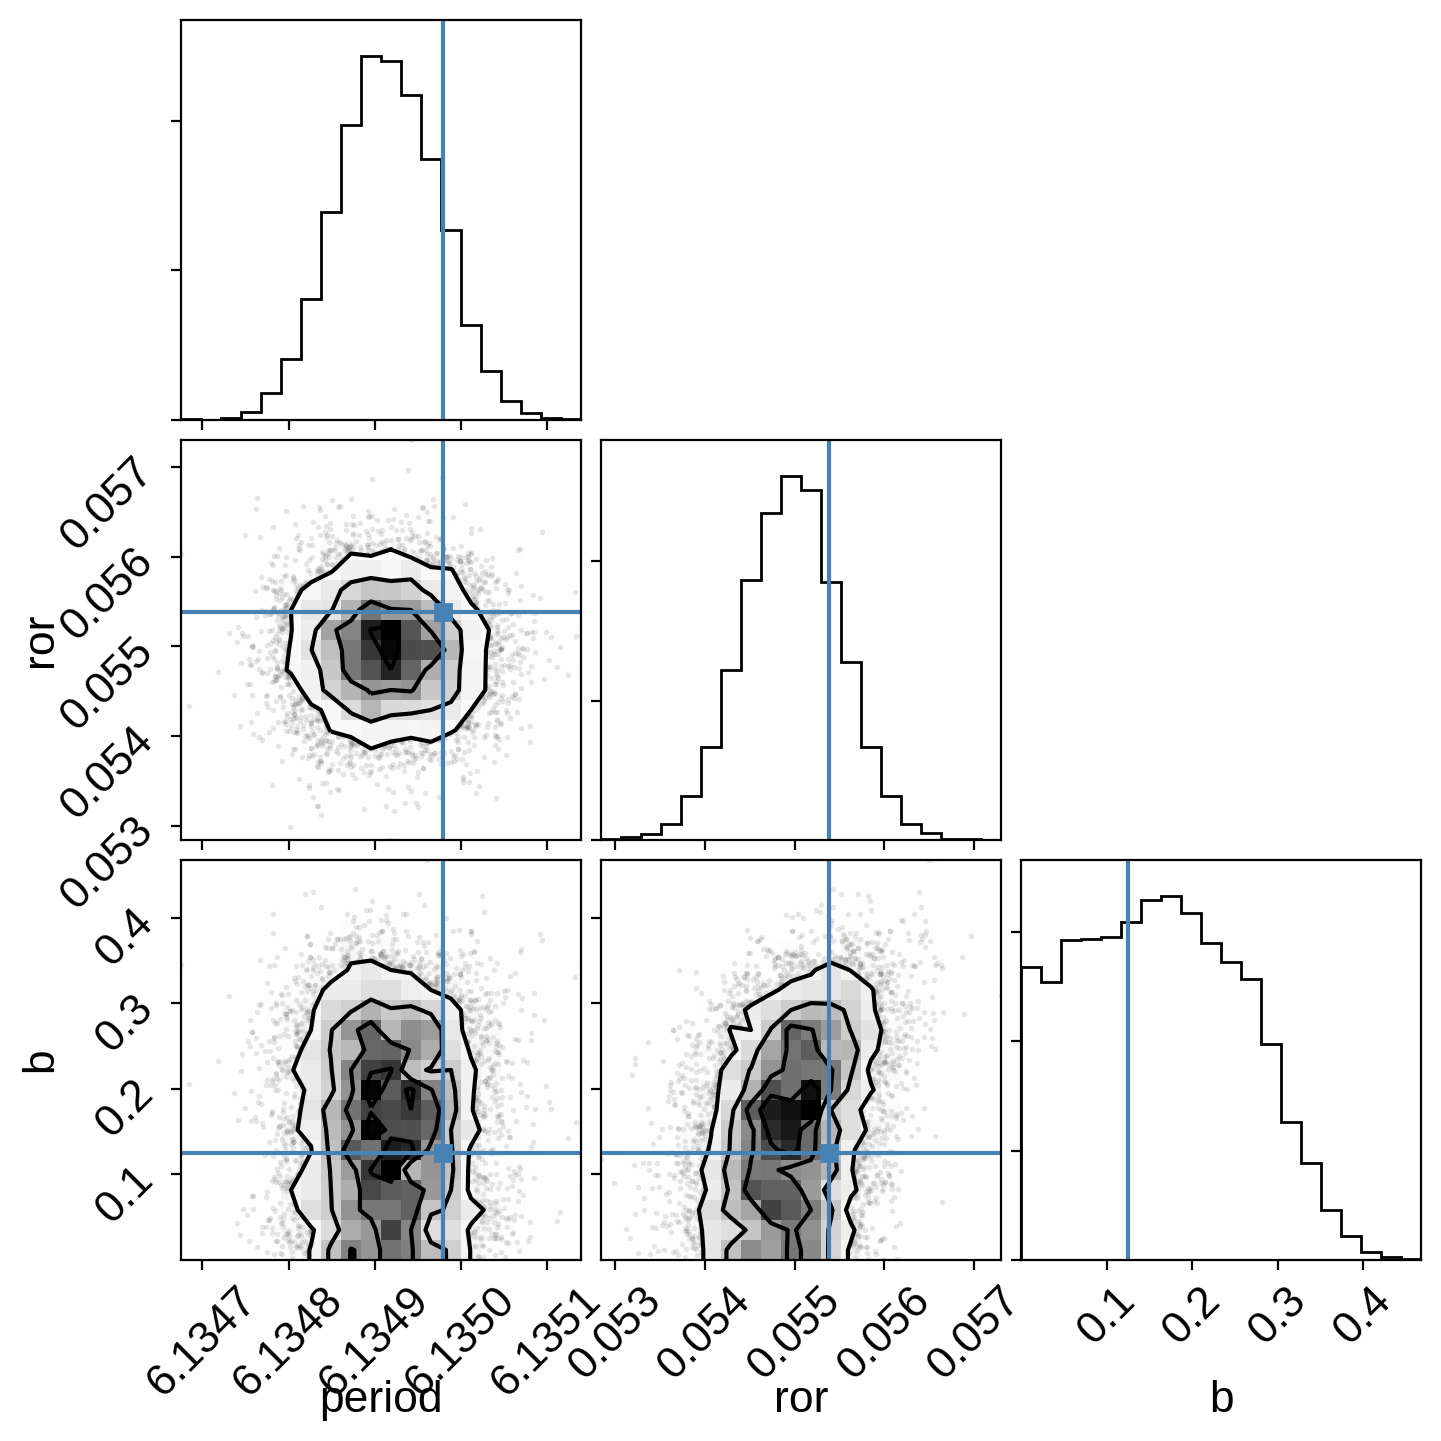

In [10]:
import corner
import astropy.units as u

samples = pm.trace_to_dataframe(trace, varnames=["period", "ror", "b"])
corner.corner(samples, truths=[6.134980, 0.05538, 0.125]);

## Bonus: eccentricity

As discussed above, we fit this model assuming a circular orbit which speeds things up for a few reasons.
First, setting eccentricity to zero means that the orbital dynamics are much simpler and more computationally efficient, since we don't need to solve Kepler's equation numerically.
But this isn't actually the main effect!
Instead the bigger issues come from the fact that the degeneracies between eccentricity, arrgument of periasteron, impact parameter, and planet radius are hard for the sampler to handle, causing the sampler's performance to plummet.
In this case, by fitting with a circular orbit where duration is one of the parameters, everything is well behaved and the sampler runs faster.

But, in this case, the planet *is* actually on an eccentric orbit, so that assumption isn't justified.
It has been recognized by various researchers over the years (I first learned about this from [Bekki Dawson](https://arxiv.org/abs/1203.5537)) that, to first order, the eccentricity mainly just changes the transit duration.
The key realization is that this can be thought of as a change in the impled density of the star.
Therefore, if you fit the transit using stellar density (or duration, in this case) as one of the parameters (*note: you must have a* different *stellar density parameter for each planet if there are more than one*), you can use an independent measurement of the stellar density to infer the eccentricity of the orbit after the fact.
All the details are described in [Dawson & Johnson (2012)](https://arxiv.org/abs/1203.5537), but here's how you can do this here using the stellar density listed in the TESS input catalog:

rho_star = 0.121689 ± 0.0281776


eccentricity = 0.46 +0.25 -0.13


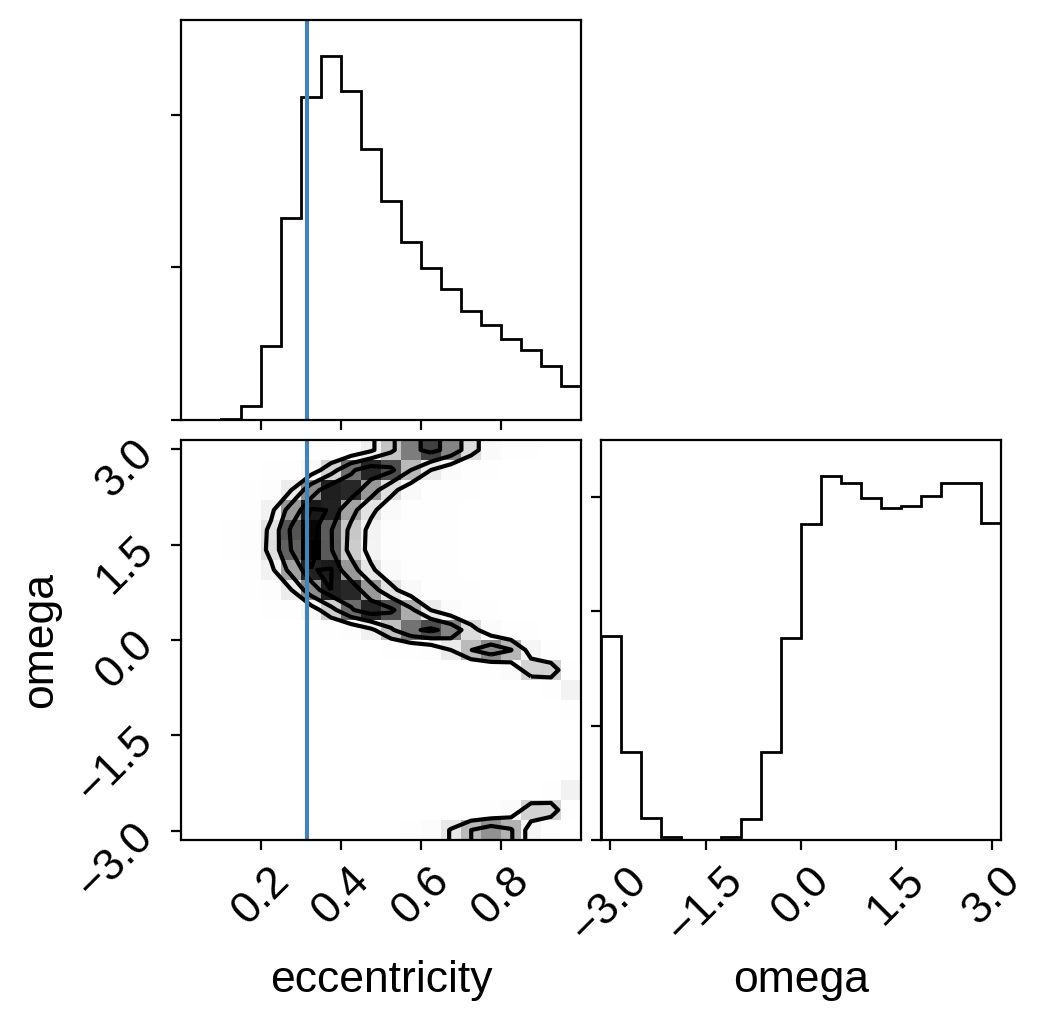

In [11]:
from astroquery.mast import Catalogs

star = Catalogs.query_object("TIC 286923464", catalog="TIC", radius=0.001)
tic_rho_star = float(star["rho"]), float(star["e_rho"])
print("rho_star = {0} ± {1}".format(*tic_rho_star))

# Extract the implied density from the fit
rho_circ = np.repeat(trace["rho_circ"], 100)

# Sample eccentricity and omega from their priors (the math might
# be a little more subtle for more informative priors, but I leave
# that as an exercise for the reader...)
ecc = np.random.uniform(0, 1, len(rho_circ))
omega = np.random.uniform(-np.pi, np.pi, len(rho_circ))

# Compute the "g" parameter from Dawson & Johnson and what true
# density that implies
g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc ** 2)
rho = rho_circ / g ** 3

# Re-weight these samples to get weighted posterior samples
log_weights = -0.5 * ((rho - tic_rho_star[0]) / tic_rho_star[1]) ** 2
weights = np.exp(log_weights - np.max(log_weights))

# Estimate the expected posterior quantiles
q = corner.quantile(ecc, [0.16, 0.5, 0.84], weights=weights)
print("eccentricity = {0:.2f} +{1[1]:.2f} -{1[0]:.2f}".format(q[1], np.diff(q)))

corner.corner(
    np.vstack((ecc, omega)).T,
    weights=weights,
    truths=[0.316, None],
    plot_datapoints=False,
    labels=["eccentricity", "omega"],
);

As you can see, this eccentricity estimate is consistent (albeit with large uncertainties) with the value that [Pepper et al. (2019)](https://arxiv.org/abs/1911.05150) measure using radial velocities and it is definitely clear that this planet is not on a circular orbit.

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [12]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [13]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.2.5},
   month = mar,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
